In [63]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb   #optuna使う場合はコメントアウト
# import optuna.integration.lightgbm as lgb  #optuna

from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [64]:
train = pd.read_csv('train.tsv', index_col=0, sep="\t") # 学習用データ DataFrame化
test = pd.read_csv('test.tsv', index_col=0, sep="\t") # 学習用データ DataFrame化
submit =pd.read_csv("sample_submit.tsv", sep="\t", index_col=0, header=None) # 応募用サンプルファイル DataFrame化

In [65]:
train

,survived,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,,
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
7,0,3,male,2.0,3,1,21.0750,S
9,1,2,female,14.0,1,0,30.0708,C
11,1,1,female,58.0,0,0,26.5500,S
...,...,...,...,...,...,...,...,...
873,0,3,male,47.0,0,0,9.0000,S
874,1,2,female,28.0,1,0,24.0000,C
879,1,1,female,56.0,0,1,83.1583,C


In [66]:
train.dtypes

survived      int64
pclass        int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
dtype: object

In [67]:
test

,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
5,3,male,NaN,0,0,8.4583,Q
6,1,male,54.0,0,0,51.8625,S
...,...,...,...,...,...,...,...
885,3,female,39.0,0,5,29.1250,Q
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S


In [68]:
#提出用フォーマット
submit

,1
0,
0,0
1,1
2,0
5,1
6,1
...,...
885,1
886,1
887,1


In [69]:
#Label Encoding

le = LabelEncoder()
le.fit(train['sex'])
train['sex'] = le.transform(train['sex']).astype("int")

le.fit(train['embarked'])
train['embarked'] = le.transform(train['embarked']).astype("int")

le.fit(test['sex'])
test['sex'] = le.transform(test['sex']).astype("int")

le.fit(test['embarked'])
test['embarked'] = le.transform(test['embarked']).astype("int")

train

,survived,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,,
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2
7,0,3,1,2.0,3,1,21.0750,2
9,1,2,0,14.0,1,0,30.0708,0
11,1,1,0,58.0,0,0,26.5500,2
...,...,...,...,...,...,...,...,...
873,0,3,1,47.0,0,0,9.0000,2
874,1,2,0,28.0,1,0,24.0000,0
879,1,1,0,56.0,0,1,83.1583,0


In [70]:
train.dtypes

survived      int64
pclass        int64
sex           int32
age         float64
sibsp         int64
parch         int64
fare        float64
embarked      int32
dtype: object

In [71]:
#特徴量同士の相関の確認

print(train.corr())

          survived    pclass       sex       age     sibsp     parch  \
survived  1.000000 -0.358097 -0.559465 -0.081394 -0.045087  0.079669   
pclass   -0.358097  1.000000  0.193761 -0.300686  0.069857 -0.015726   
sex      -0.559465  0.193761  1.000000  0.072899 -0.097883 -0.220046   
age      -0.081394 -0.300686  0.072899  1.000000 -0.283126 -0.153382   
sibsp    -0.045087  0.069857 -0.097883 -0.283126  1.000000  0.423522   
parch     0.079669 -0.015726 -0.220046 -0.153382  0.423522  1.000000   
fare      0.258605 -0.549651 -0.168935  0.098488  0.164773  0.241855   
embarked -0.173428  0.103049  0.112383  0.010552  0.104772  0.058022   

              fare  embarked  
survived  0.258605 -0.173428  
pclass   -0.549651  0.103049  
sex      -0.168935  0.112383  
age       0.098488  0.010552  
sibsp     0.164773  0.104772  
parch     0.241855  0.058022  
fare      1.000000 -0.157135  
embarked -0.157135  1.000000  


In [72]:
train = train.reset_index(drop=True)
train

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,1,1,0,35.0,1,0,53.1000,2
1,0,3,1,35.0,0,0,8.0500,2
2,0,3,1,2.0,3,1,21.0750,2
3,1,2,0,14.0,1,0,30.0708,0
4,1,1,0,58.0,0,0,26.5500,2
...,...,...,...,...,...,...,...,...
440,0,3,1,47.0,0,0,9.0000,2
441,1,2,0,28.0,1,0,24.0000,0
442,1,1,0,56.0,0,1,83.1583,0
443,0,3,1,25.0,0,0,7.0500,2


In [73]:
#クロスバリデーションFold数
FOLD  = 5

kf = StratifiedKFold(n_splits=FOLD, random_state=2022, shuffle=True)
for i, (train_idx, val_idx) in enumerate(kf.split(train, train["survived"])):
    print(train_idx)
    print(val_idx)
    train.loc[val_idx, "fold"] = int(i)

[  1   2   3   4   5   6   7   8   9  10  11  12  15  16  17  20  21  22
  23  24  25  26  27  29  31  33  34  35  36  39  40  41  42  43  44  45
  47  48  49  50  53  54  56  57  58  60  61  62  63  65  66  67  68  69
  70  71  72  73  74  77  78  79  80  83  84  85  86  87  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 125 127 128 129 131 132
 133 134 137 138 140 141 142 143 144 145 146 147 148 149 150 153 154 156
 159 161 162 163 164 165 166 167 168 170 171 172 174 175 176 177 178 179
 180 181 182 183 184 185 187 189 190 191 192 193 194 198 199 200 202 203
 205 207 208 209 210 211 212 213 214 215 217 218 219 221 222 223 224 227
 228 230 232 233 235 236 237 238 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 255 257 259 261 262 263 264 265 268 269 271 272 273 274
 275 276 277 279 280 281 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299 300 301 302 303 304 305 306 30

In [74]:
def cal_roc(y_true, y_pred):
  return roc_auc_score(y_true, y_pred)

In [75]:
lgb_fit_params ={'num_boost_rounds': 10000,
                 'early_stopping_rounds': 50,
                 'verbose_eval': 10,
                }


lgb_model_params = {'boosting_type': 'gbdt',
                    'device': 'gpu', 
                    'metric': 'auc',
                    'learning_rate': 0.05,
                    'max_depth': -1,
                    'num_leaves': 72,
                    'min_data_in_leaf': 20,
                    'max_bin': 255,
                    'verbose': -1,
                    'n_jobs': -1,
                    'feature_pre_filter': False,
                    'bagging_fraction': 0.9918357136100413,
                    'bagging_freq': 4,
                    'feature_fraction': 0.9840000000000001,
                    'lambda_l1': 7.386178645626934,
                    'lambda_l2': 4.572888900518312e-08,
                    'min_child_samples': 20}

In [76]:
Fold_score = []
models = []
total_pred = []

for i in range(FOLD):
    train_df = train[train["fold"]!=i]
    val_df = train[train["fold"]==i]
    X_train, y_train = train_df.drop(columns=["survived", "fold"]), train_df["survived"].values
    X_val, y_val = val_df.drop(columns=["survived", "fold"]), val_df["survived"].values
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val)

    model = lgb.train(lgb_model_params,
                        train_set=lgb_train,
                        valid_sets=[lgb_train, lgb_eval],
                        verbose_eval=lgb_fit_params['verbose_eval'],
                        num_boost_round=lgb_fit_params['num_boost_rounds'],
                        callbacks=[lgb.early_stopping(lgb_fit_params['early_stopping_rounds'])],
                        )

    val_pred = model.predict(X_val)
    score = cal_roc(y_val, val_pred)
    Fold_score.append(score)
    models.append(model)
    total_pred.extend(y_val)
    
    print(f"ROC: {score}")
    
finalscore = sum(Fold_score)/FOLD
print(f"Final ROC: {finalscore}")

[I 2023-07-04 00:24:13,798] A new study created in memory with name: no-name-b6c95792-0f9e-4433-a71d-08f6da4bf0e8
feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 50 rounds
[10]	valid_0's auc: 0.85341	valid_1's auc: 0.859801


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's auc: 0.853918	valid_1's auc: 0.845388
[30]	valid_0's auc: 0.855675	valid_1's auc: 0.839623
[40]	valid_0's auc: 0.858958	valid_1's auc: 0.833071


feature_fraction, val_score: 0.859801:  14%|#4        | 1/7 [00:00<00:01,  4.18it/s]

[50]	valid_0's auc: 0.863784	valid_1's auc: 0.841457
Early stopping, best iteration is:
[5]	valid_0's auc: 0.85341	valid_1's auc: 0.859801
[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[19]	valid_0's auc: 0.869792	valid_1's auc: 0.865304


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.865304:  29%|##8       | 2/7 [00:00<00:01,  4.59it/s]

[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436

c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.865304:  43%|####2     | 3/7 [00:00<00:00,  4.65it/s]


[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[19]	valid_0's auc: 0.869792	valid_1's auc: 0.865304
[10]	valid_0's auc: 0.855347	valid_1's auc: 0.84696
[20]	valid_0's auc: 0.862914	valid_1's auc: 0.866614


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.865304:  57%|#####7    | 4/7 [00:00<00:00,  4.95it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's auc: 0.864309	valid_1's auc: 0.862421
[40]	valid_0's auc: 0.86559	valid_1's auc: 0.855608
[50]	valid_0's auc: 0.866082	valid_1's auc: 0.857442
[60]	valid_0's auc: 0.865491	valid_1's auc: 0.859015
Early stopping, best iteration is:
[19]	valid_0's auc: 0.869792	valid_1's auc: 0.865304
[10]	valid_0's auc: 0.861125	valid_1's auc: 0.847222
[20]	valid_0's auc: 0.862093	valid_1's auc: 0.860063
[30]	valid_0's auc: 0.861223	valid_1's auc: 0.861111
[40]	valid_0's auc: 0.865229	valid_1's auc: 0.859801


feature_fraction, val_score: 0.865304:  71%|#######1  | 5/7 [00:01<00:00,  4.92it/s]

[50]	valid_0's auc: 0.866985	valid_1's auc: 0.857966
[60]	valid_0's auc: 0.868052	valid_1's auc: 0.859539
Early stopping, best iteration is:
[19]	valid_0's auc: 0.869792	valid_1's auc: 0.865304
[10]	valid_0's auc: 0.867609	valid_1's auc: 0.852987
[20]	valid_0's auc: 0.869152	valid_1's auc: 0.850891
[30]	valid_0's auc: 0.86234	valid_1's auc: 0.850891
[40]	valid_0's auc: 0.86426	valid_1's auc: 0.855084
[50]	valid_0's auc: 0.865672	valid_1's auc: 0.851939


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.865304:  86%|########5 | 6/7 [00:01<00:00,  4.87it/s]

[60]	valid_0's auc: 0.865803	valid_1's auc: 0.857442
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.867609	valid_1's auc: 0.852987
[20]	valid_0's auc: 0.869152	valid_1's auc: 0.850891
[30]	valid_0's auc: 0.86234	valid_1's auc: 0.850891
[40]	valid_0's auc: 0.86426	valid_1's auc: 0.855084
[50]	valid_0's auc: 0.865672	valid_1's auc: 0.851939


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.865304: 100%|##########| 7/7 [00:01<00:00,  4.77it/s]


[60]	valid_0's auc: 0.865803	valid_1's auc: 0.857442
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229


num_leaves, val_score: 0.865304:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:   0%|          | 0/20 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229


num_leaves, val_score: 0.865304:   5%|5         | 1/20 [00:00<00:03,  5.70it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436

num_leaves, val_score: 0.865304:  10%|#         | 2/20 [00:00<00:03,  5.26it/s]


[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  15%|#5        | 3/20 [00:00<00:03,  5.28it/s]

[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  20%|##        | 4/20 [00:00<00:03,  5.10it/s]

[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  25%|##5       | 5/20 [00:00<00:02,  5.12it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  30%|###       | 6/20 [00:01<00:02,  5.01it/s]

[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  35%|###5      | 7/20 [00:01<00:02,  5.02it/s]

[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  40%|####      | 8/20 [00:01<00:02,  4.63it/s]

[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  45%|####5     | 9/20 [00:01<00:02,  4.75it/s]

[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  50%|#####     | 10/20 [00:02<00:02,  4.91it/s]

[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  55%|#####5    | 11/20 [00:02<00:01,  5.01it/s]

[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  60%|######    | 12/20 [00:02<00:01,  5.12it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  65%|######5   | 13/20 [00:02<00:01,  5.12it/s]

[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  70%|#######   | 14/20 [00:02<00:01,  5.07it/s]

[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  75%|#######5  | 15/20 [00:02<00:01,  4.99it/s]

[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  80%|########  | 16/20 [00:03<00:00,  4.92it/s]

[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  85%|########5 | 17/20 [00:03<00:00,  5.01it/s]

[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  90%|######### | 18/20 [00:03<00:00,  5.16it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304:  95%|#########5| 19/20 [00:03<00:00,  5.09it/s]

[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436
[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.8562	valid_1's auc: 0.846436


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.865304: 100%|##########| 20/20 [00:03<00:00,  5.04it/s]


[20]	valid_0's auc: 0.869103	valid_1's auc: 0.865304
[30]	valid_0's auc: 0.863538	valid_1's auc: 0.865828
[40]	valid_0's auc: 0.866132	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.867445	valid_1's auc: 0.861897
[60]	valid_0's auc: 0.8671	valid_1's auc: 0.862421
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229


bagging, val_score: 0.865304:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.865304:  10%|#         | 1/10 [00:00<00:02,  4.41it/s]

[10]	valid_0's auc: 0.849815	valid_1's auc: 0.858753
[20]	valid_0's auc: 0.857743	valid_1's auc: 0.836478
[30]	valid_0's auc: 0.857678	valid_1's auc: 0.839099
[40]	valid_0's auc: 0.859713	valid_1's auc: 0.844864
[50]	valid_0's auc: 0.860403	valid_1's auc: 0.84565
[60]	valid_0's auc: 0.861207	valid_1's auc: 0.847746
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.858613	valid_1's auc: 0.85587
[20]	valid_0's auc: 0.860074	valid_1's auc: 0.858229
[30]	valid_0's auc: 0.862143	valid_1's auc: 0.856132


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.865304:  20%|##        | 2/10 [00:00<00:01,  5.17it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[40]	valid_0's auc: 0.862832	valid_1's auc: 0.855346
[50]	valid_0's auc: 0.86408	valid_1's auc: 0.855346
[60]	valid_0's auc: 0.864293	valid_1's auc: 0.854822
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.834729	valid_1's auc: 0.865042
[20]	valid_0's auc: 0.847943	valid_1's auc: 0.865566


bagging, val_score: 0.871855:  30%|###       | 3/10 [00:00<00:01,  4.55it/s]

[30]	valid_0's auc: 0.844529	valid_1's auc: 0.863208
[40]	valid_0's auc: 0.843495	valid_1's auc: 0.866352
[50]	valid_0's auc: 0.841262	valid_1's auc: 0.867662
Early stopping, best iteration is:
[5]	valid_0's auc: 0.830707	valid_1's auc: 0.871855
[10]	valid_0's auc: 0.843741	valid_1's auc: 0.863994


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.872379:  40%|####      | 4/10 [00:00<00:01,  4.10it/s]

[20]	valid_0's auc: 0.847779	valid_1's auc: 0.871855
[30]	valid_0's auc: 0.845349	valid_1's auc: 0.870807
[40]	valid_0's auc: 0.845514	valid_1's auc: 0.869235
[50]	valid_0's auc: 0.844069	valid_1's auc: 0.870283
[60]	valid_0's auc: 0.844299	valid_1's auc: 0.870283
Early stopping, best iteration is:
[17]	valid_0's auc: 0.84883	valid_1's auc: 0.872379


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.872379:  50%|#####     | 5/10 [00:01<00:01,  3.86it/s]

[10]	valid_0's auc: 0.835123	valid_1's auc: 0.865042
[20]	valid_0's auc: 0.847779	valid_1's auc: 0.865042
[30]	valid_0's auc: 0.845448	valid_1's auc: 0.863208
[40]	valid_0's auc: 0.844512	valid_1's auc: 0.866876
[50]	valid_0's auc: 0.841508	valid_1's auc: 0.868187
[60]	valid_0's auc: 0.840523	valid_1's auc: 0.868187
Early stopping, best iteration is:
[17]	valid_0's auc: 0.84883	valid_1's auc: 0.872379


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.872379:  60%|######    | 6/10 [00:01<00:01,  3.76it/s]

[10]	valid_0's auc: 0.837716	valid_1's auc: 0.866876
[20]	valid_0's auc: 0.844611	valid_1's auc: 0.868187
[30]	valid_0's auc: 0.84072	valid_1's auc: 0.867925
[40]	valid_0's auc: 0.841196	valid_1's auc: 0.87369
[50]	valid_0's auc: 0.839686	valid_1's auc: 0.873166
[60]	valid_0's auc: 0.83985	valid_1's auc: 0.872642
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.872379:  70%|#######   | 7/10 [00:01<00:00,  3.88it/s]

[10]	valid_0's auc: 0.837372	valid_1's auc: 0.856918
[20]	valid_0's auc: 0.842575	valid_1's auc: 0.87369
[30]	valid_0's auc: 0.845678	valid_1's auc: 0.866352
[40]	valid_0's auc: 0.845546	valid_1's auc: 0.866876
[50]	valid_0's auc: 0.843314	valid_1's auc: 0.866614
[60]	valid_0's auc: 0.843248	valid_1's auc: 0.868711
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.872379:  80%|########  | 8/10 [00:01<00:00,  3.97it/s]

[10]	valid_0's auc: 0.833038	valid_1's auc: 0.853774
[20]	valid_0's auc: 0.839916	valid_1's auc: 0.865566
[30]	valid_0's auc: 0.842542	valid_1's auc: 0.865566
[40]	valid_0's auc: 0.840622	valid_1's auc: 0.8674
[50]	valid_0's auc: 0.83944	valid_1's auc: 0.871331
[60]	valid_0's auc: 0.840704	valid_1's auc: 0.872379
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.847845	valid_1's auc: 0.859015
[20]	valid_0's auc: 0.845809	valid_1's auc: 0.857704
[30]	valid_0's auc: 0.849191	valid_1's auc: 0.858229
[40]	valid_0's auc: 0.848551	valid_1's auc: 0.863732
[50]	valid_0's auc: 0.848239	valid_1's auc: 0.859015
[60]	valid_0's auc: 0.84878	valid_1's auc: 0.860587


bagging, val_score: 0.872379:  90%|######### | 9/10 [00:02<00:00,  3.31it/s]

Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229
[10]	valid_0's auc: 0.84704	valid_1's auc: 0.853512
[20]	valid_0's auc: 0.847155	valid_1's auc: 0.850629
[30]	valid_0's auc: 0.846055	valid_1's auc: 0.859539
[40]	valid_0's auc: 0.848288	valid_1's auc: 0.860587


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.872379: 100%|##########| 10/10 [00:02<00:00,  3.83it/s]


[50]	valid_0's auc: 0.851555	valid_1's auc: 0.861373
[60]	valid_0's auc: 0.849962	valid_1's auc: 0.861897
Early stopping, best iteration is:
[18]	valid_0's auc: 0.87017	valid_1's auc: 0.858229


feature_fraction_stage2, val_score: 0.872379:   0%|          | 0/6 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.834269	valid_1's auc: 0.874476
[20]	valid_0's auc: 0.838077	valid_1's auc: 0.869235
[30]	valid_0's auc: 0.843347	valid_1's auc: 0.866876


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.878931:  17%|#6        | 1/6 [00:00<00:01,  4.06it/s]

[40]	valid_0's auc: 0.8453	valid_1's auc: 0.868187
[50]	valid_0's auc: 0.845711	valid_1's auc: 0.866614
Early stopping, best iteration is:
[3]	valid_0's auc: 0.815326	valid_1's auc: 0.878931
[10]	valid_0's auc: 0.834269	valid_1's auc: 0.874476

c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.878931:  33%|###3      | 2/6 [00:00<00:00,  4.06it/s]


[20]	valid_0's auc: 0.838077	valid_1's auc: 0.869235
[30]	valid_0's auc: 0.843347	valid_1's auc: 0.866876
[40]	valid_0's auc: 0.8453	valid_1's auc: 0.868187
[50]	valid_0's auc: 0.845711	valid_1's auc: 0.866614
Early stopping, best iteration is:
[3]	valid_0's auc: 0.815326	valid_1's auc: 0.878931


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.878931:  50%|#####     | 3/6 [00:00<00:00,  3.80it/s]

[10]	valid_0's auc: 0.843741	valid_1's auc: 0.863994
[20]	valid_0's auc: 0.847779	valid_1's auc: 0.871855
[30]	valid_0's auc: 0.845349	valid_1's auc: 0.870807
[40]	valid_0's auc: 0.845514	valid_1's auc: 0.869235
[50]	valid_0's auc: 0.844069	valid_1's auc: 0.870283
Early stopping, best iteration is:
[3]	valid_0's auc: 0.815326	valid_1's auc: 0.878931


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.878931:  67%|######6   | 4/6 [00:01<00:00,  3.82it/s]

[10]	valid_0's auc: 0.843741	valid_1's auc: 0.863994
[20]	valid_0's auc: 0.847779	valid_1's auc: 0.871855
[30]	valid_0's auc: 0.845349	valid_1's auc: 0.870807
[40]	valid_0's auc: 0.845514	valid_1's auc: 0.869235
[50]	valid_0's auc: 0.844069	valid_1's auc: 0.870283
Early stopping, best iteration is:
[3]	valid_0's auc: 0.815326	valid_1's auc: 0.878931


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.878931:  83%|########3 | 5/6 [00:01<00:00,  4.02it/s]

[10]	valid_0's auc: 0.834269	valid_1's auc: 0.874476
[20]	valid_0's auc: 0.838077	valid_1's auc: 0.869235
[30]	valid_0's auc: 0.843347	valid_1's auc: 0.866876
[40]	valid_0's auc: 0.8453	valid_1's auc: 0.868187
[50]	valid_0's auc: 0.845711	valid_1's auc: 0.866614
Early stopping, best iteration is:
[3]	valid_0's auc: 0.815326	valid_1's auc: 0.878931


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.878931: 100%|##########| 6/6 [00:01<00:00,  3.98it/s]


[10]	valid_0's auc: 0.843741	valid_1's auc: 0.863994
[20]	valid_0's auc: 0.847779	valid_1's auc: 0.871855
[30]	valid_0's auc: 0.845349	valid_1's auc: 0.870807
[40]	valid_0's auc: 0.845514	valid_1's auc: 0.869235
[50]	valid_0's auc: 0.844069	valid_1's auc: 0.870283
Early stopping, best iteration is:
[3]	valid_0's auc: 0.815326	valid_1's auc: 0.878931


regularization_factors, val_score: 0.878931:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:   5%|5         | 1/20 [00:00<00:04,  4.25it/s]

[10]	valid_0's auc: 0.845448	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.860731	valid_1's auc: 0.856918
[30]	valid_0's auc: 0.873683	valid_1's auc: 0.848532
[40]	valid_0's auc: 0.882695	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888916	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  10%|#         | 2/20 [00:00<00:04,  4.03it/s]

[10]	valid_0's auc: 0.845448	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.860731	valid_1's auc: 0.856918
[30]	valid_0's auc: 0.87365	valid_1's auc: 0.848532
[40]	valid_0's auc: 0.882695	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888883	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  15%|#5        | 3/20 [00:00<00:04,  3.97it/s]

[10]	valid_0's auc: 0.845448	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.860698	valid_1's auc: 0.856918
[30]	valid_0's auc: 0.873748	valid_1's auc: 0.848532
[40]	valid_0's auc: 0.882695	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.88931	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  20%|##        | 4/20 [00:01<00:04,  3.71it/s]

[10]	valid_0's auc: 0.844824	valid_1's auc: 0.845388
[20]	valid_0's auc: 0.860567	valid_1's auc: 0.857442
[30]	valid_0's auc: 0.873387	valid_1's auc: 0.849057
[40]	valid_0's auc: 0.882465	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888686	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  25%|##5       | 5/20 [00:01<00:03,  3.85it/s]

[10]	valid_0's auc: 0.844824	valid_1's auc: 0.845388
[20]	valid_0's auc: 0.860567	valid_1's auc: 0.857966
[30]	valid_0's auc: 0.873387	valid_1's auc: 0.849057
[40]	valid_0's auc: 0.882465	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888686	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  30%|###       | 6/20 [00:01<00:03,  3.95it/s]

[10]	valid_0's auc: 0.84489	valid_1's auc: 0.845388
[20]	valid_0's auc: 0.860567	valid_1's auc: 0.857966
[30]	valid_0's auc: 0.873387	valid_1's auc: 0.849057
[40]	valid_0's auc: 0.882399	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888588	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  35%|###5      | 7/20 [00:01<00:03,  3.94it/s]

[10]	valid_0's auc: 0.845448	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.860731	valid_1's auc: 0.856918
[30]	valid_0's auc: 0.873748	valid_1's auc: 0.848532
[40]	valid_0's auc: 0.882695	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.889277	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  40%|####      | 8/20 [00:02<00:03,  3.91it/s]

[10]	valid_0's auc: 0.844824	valid_1's auc: 0.845388
[20]	valid_0's auc: 0.860567	valid_1's auc: 0.857966
[30]	valid_0's auc: 0.873387	valid_1's auc: 0.849057
[40]	valid_0's auc: 0.882465	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888686	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  45%|####5     | 9/20 [00:02<00:02,  3.96it/s]

[10]	valid_0's auc: 0.844824	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.860567	valid_1's auc: 0.857442
[30]	valid_0's auc: 0.873617	valid_1's auc: 0.849057
[40]	valid_0's auc: 0.882465	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888686	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  50%|#####     | 10/20 [00:02<00:02,  4.00it/s]

[10]	valid_0's auc: 0.845448	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.860632	valid_1's auc: 0.857442
[30]	valid_0's auc: 0.873683	valid_1's auc: 0.849057
[40]	valid_0's auc: 0.882465	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888752	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  55%|#####5    | 11/20 [00:02<00:02,  3.79it/s]

[10]	valid_0's auc: 0.845448	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.860632	valid_1's auc: 0.857442
[30]	valid_0's auc: 0.87365	valid_1's auc: 0.849057
[40]	valid_0's auc: 0.882465	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888752	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  60%|######    | 12/20 [00:03<00:02,  3.83it/s]

[10]	valid_0's auc: 0.844824	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.860632	valid_1's auc: 0.857442
[30]	valid_0's auc: 0.873617	valid_1's auc: 0.849057
[40]	valid_0's auc: 0.882465	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888686	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  65%|######5   | 13/20 [00:03<00:01,  3.88it/s]

[10]	valid_0's auc: 0.845218	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.86119	valid_1's auc: 0.856918
[30]	valid_0's auc: 0.874027	valid_1's auc: 0.848532
[40]	valid_0's auc: 0.88258	valid_1's auc: 0.854298
[50]	valid_0's auc: 0.89	valid_1's auc: 0.856394
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  70%|#######   | 14/20 [00:03<00:01,  3.92it/s]

[10]	valid_0's auc: 0.834663	valid_1's auc: 0.859277
[20]	valid_0's auc: 0.851193	valid_1's auc: 0.862945
[30]	valid_0's auc: 0.85904	valid_1's auc: 0.858753
[40]	valid_0's auc: 0.865311	valid_1's auc: 0.861635
[50]	valid_0's auc: 0.870449	valid_1's auc: 0.862159
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  75%|#######5  | 15/20 [00:03<00:01,  3.89it/s]

[10]	valid_0's auc: 0.845218	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.860632	valid_1's auc: 0.857966
[30]	valid_0's auc: 0.873404	valid_1's auc: 0.849581
[40]	valid_0's auc: 0.882974	valid_1's auc: 0.854822
[50]	valid_0's auc: 0.891395	valid_1's auc: 0.85587
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  80%|########  | 16/20 [00:04<00:01,  3.86it/s]

[10]	valid_0's auc: 0.845218	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.861322	valid_1's auc: 0.856918
[30]	valid_0's auc: 0.874175	valid_1's auc: 0.849057
[40]	valid_0's auc: 0.882498	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888851	valid_1's auc: 0.855346
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  85%|########5 | 17/20 [00:04<00:00,  3.82it/s]

[10]	valid_0's auc: 0.839998	valid_1's auc: 0.853774
[20]	valid_0's auc: 0.852687	valid_1's auc: 0.859801
[30]	valid_0's auc: 0.862159	valid_1's auc: 0.853774
[40]	valid_0's auc: 0.870761	valid_1's auc: 0.857442
[50]	valid_0's auc: 0.877031	valid_1's auc: 0.85718
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  90%|######### | 18/20 [00:04<00:00,  3.89it/s]

[10]	valid_0's auc: 0.844594	valid_1's auc: 0.845388
[20]	valid_0's auc: 0.860928	valid_1's auc: 0.857442
[30]	valid_0's auc: 0.87319	valid_1's auc: 0.849057
[40]	valid_0's auc: 0.882235	valid_1's auc: 0.854298
[50]	valid_0's auc: 0.888292	valid_1's auc: 0.855346
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386:  95%|#########5| 19/20 [00:04<00:00,  3.83it/s]

[10]	valid_0's auc: 0.845153	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.86119	valid_1's auc: 0.856918
[30]	valid_0's auc: 0.874044	valid_1's auc: 0.848532
[40]	valid_0's auc: 0.882728	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.889245	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.883386: 100%|##########| 20/20 [00:05<00:00,  3.89it/s]


[10]	valid_0's auc: 0.845087	valid_1's auc: 0.845388
[20]	valid_0's auc: 0.861552	valid_1's auc: 0.860587
[30]	valid_0's auc: 0.871499	valid_1's auc: 0.853774
[40]	valid_0's auc: 0.880282	valid_1's auc: 0.862683
[50]	valid_0's auc: 0.889261	valid_1's auc: 0.861635
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


min_data_in_leaf, val_score: 0.883386:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.883386:  20%|##        | 1/5 [00:00<00:00,  4.41it/s]

[10]	valid_0's auc: 0.845448	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.860731	valid_1's auc: 0.856918
[30]	valid_0's auc: 0.873683	valid_1's auc: 0.848532
[40]	valid_0's auc: 0.882695	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888916	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.883386:  40%|####      | 2/5 [00:00<00:00,  4.26it/s]

[10]	valid_0's auc: 0.845448	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.860731	valid_1's auc: 0.856918
[30]	valid_0's auc: 0.873683	valid_1's auc: 0.848532
[40]	valid_0's auc: 0.882695	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888916	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.883386:  60%|######    | 3/5 [00:00<00:00,  4.14it/s]

[10]	valid_0's auc: 0.845448	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.860731	valid_1's auc: 0.856918
[30]	valid_0's auc: 0.873683	valid_1's auc: 0.848532
[40]	valid_0's auc: 0.882695	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888916	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.883386:  80%|########  | 4/5 [00:01<00:00,  3.85it/s]

[10]	valid_0's auc: 0.845448	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.860731	valid_1's auc: 0.856918
[30]	valid_0's auc: 0.873683	valid_1's auc: 0.848532
[40]	valid_0's auc: 0.882695	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888916	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.883386: 100%|##########| 5/5 [00:01<00:00,  3.98it/s]
[I 2023-07-04 00:24:29,774] A new study created in memory with name: no-name-34a4c9b8-4c7a-47ec-8eef-6ee779674934


[10]	valid_0's auc: 0.845448	valid_1's auc: 0.845912
[20]	valid_0's auc: 0.860731	valid_1's auc: 0.856918
[30]	valid_0's auc: 0.873683	valid_1's auc: 0.848532
[40]	valid_0's auc: 0.882695	valid_1's auc: 0.853774
[50]	valid_0's auc: 0.888916	valid_1's auc: 0.854822
Early stopping, best iteration is:
[1]	valid_0's auc: 0.811337	valid_1's auc: 0.883386
ROC: 0.8833857442348009


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.834906:  14%|#4        | 1/7 [00:00<00:01,  5.77it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906


feature_fraction, val_score: 0.834906:  29%|##8       | 2/7 [00:00<00:00,  5.41it/s]

[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[10]	valid_0's auc: 0.864753	valid_1's auc: 0.814465


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.834906:  43%|####2     | 3/7 [00:00<00:00,  5.09it/s]

[20]	valid_0's auc: 0.868331	valid_1's auc: 0.812893
[30]	valid_0's auc: 0.87081	valid_1's auc: 0.817086
[40]	valid_0's auc: 0.870728	valid_1's auc: 0.819444
[50]	valid_0's auc: 0.870695	valid_1's auc: 0.81892
[60]	valid_0's auc: 0.871089	valid_1's auc: 0.822065
Early stopping, best iteration is:
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[10]	valid_0's auc: 0.864441	valid_1's auc: 0.812893
[20]	valid_0's auc: 0.871762	valid_1's auc: 0.827044
[30]	valid_0's auc: 0.872041	valid_1's auc: 0.827044


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.834906:  57%|#####7    | 4/7 [00:00<00:00,  5.27it/s]

[40]	valid_0's auc: 0.872419	valid_1's auc: 0.823375
[50]	valid_0's auc: 0.871729	valid_1's auc: 0.824423
[60]	valid_0's auc: 0.871204	valid_1's auc: 0.827044
Early stopping, best iteration is:
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[10]	valid_0's auc: 0.859746	valid_1's auc: 0.800052
[20]	valid_0's auc: 0.868183	valid_1's auc: 0.814203
[30]	valid_0's auc: 0.870794	valid_1's auc: 0.816562
[40]	valid_0's auc: 0.869579	valid_1's auc: 0.816562
[50]	valid_0's auc: 0.869743	valid_1's auc: 0.81761
[60]	valid_0's auc: 0.869349	valid_1's auc: 0.816562
Early stopping, best iteration is:
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.834906:  71%|#######1  | 5/7 [00:00<00:00,  5.43it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.834906:  86%|########5 | 6/7 [00:01<00:00,  5.46it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm

[10]	valid_0's auc: 0.865869	valid_1's auc: 0.812631
[20]	valid_0's auc: 0.866722	valid_1's auc: 0.823637
[30]	valid_0's auc: 0.870777	valid_1's auc: 0.82521
[40]	valid_0's auc: 0.871959	valid_1's auc: 0.823375
[50]	valid_0's auc: 0.870941	valid_1's auc: 0.821803
[60]	valid_0's auc: 0.869858	valid_1's auc: 0.820231
Early stopping, best iteration is:
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[10]	valid_0's auc: 0.865869	valid_1's auc: 0.812631
[20]	valid_0's auc: 0.866722	valid_1's auc: 0.823637
[30]	valid_0's auc: 0.870777	valid_1's auc: 0.82521


feature_fraction, val_score: 0.834906: 100%|##########| 7/7 [00:01<00:00,  5.40it/s]


[40]	valid_0's auc: 0.871959	valid_1's auc: 0.823375
[50]	valid_0's auc: 0.870941	valid_1's auc: 0.821803
[60]	valid_0's auc: 0.869858	valid_1's auc: 0.820231
Early stopping, best iteration is:
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906


num_leaves, val_score: 0.834906:   0%|          | 0/20 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.834906:   5%|5         | 1/20 [00:00<00:03,  5.65it/s]

[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.834906:  10%|#         | 2/20 [00:00<00:03,  5.25it/s]

[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.834906:  15%|#5        | 3/20 [00:00<00:03,  5.31it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237


num_leaves, val_score: 0.834906:  20%|##        | 4/20 [00:00<00:03,  5.13it/s]

[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.834906:  25%|##5       | 5/20 [00:00<00:02,  5.06it/s]

[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[10]	valid_0's auc: 0.863456	valid_1's auc: 0.832285
[20]	valid_0's auc: 0.870203	valid_1's auc: 0.831237
[30]	valid_0's auc: 0.870432	valid_1's auc: 0.828616
[40]	valid_0's auc: 0.870432	valid_1's auc: 0.827568
[50]	valid_0's auc: 0.870711	valid_1's auc: 0.828092


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.836216:  30%|###       | 6/20 [00:01<00:02,  4.81it/s]

[60]	valid_0's auc: 0.87035	valid_1's auc: 0.828092
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.836216:  35%|###5      | 7/20 [00:01<00:02,  4.59it/s]

[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216
[10]	valid_0's auc: 0.863456	valid_1's auc: 0.832285
[20]	valid_0's auc: 0.870203	valid_1's auc: 0.831237
[30]	valid_0's auc: 0.870432	valid_1's auc: 0.828616
[40]	valid_0's auc: 0.870432	valid_1's auc: 0.827568


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.836216:  40%|####      | 8/20 [00:01<00:02,  4.84it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's auc: 0.870711	valid_1's auc: 0.828092
[60]	valid_0's auc: 0.87035	valid_1's auc: 0.828092
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119


num_leaves, val_score: 0.836216:  40%|####      | 8/20 [00:01<00:02,  4.84it/s]

[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216


num_leaves, val_score: 0.836216:  45%|####5     | 9/20 [00:01<00:02,  5.01it/s]

[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.836216:  50%|#####     | 10/20 [00:01<00:01,  5.19it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216


num_leaves, val_score: 0.836216:  55%|#####5    | 11/20 [00:02<00:01,  5.15it/s]

[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906

c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.836216:  60%|######    | 12/20 [00:02<00:01,  4.64it/s]


[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.836216:  65%|######5   | 13/20 [00:02<00:01,  4.58it/s]

[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.836216:  70%|#######   | 14/20 [00:02<00:01,  4.74it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216
[10]	valid_0's auc: 0.862717	valid_1's auc: 0.820755
[20]	valid_0's auc: 0.863144	valid_1's auc: 0.819969
[30]	valid_0's auc: 0.863866	valid_1's auc: 0.813679
[40]	valid_0's auc: 0.864244	valid_1's auc: 0.810797


num_leaves, val_score: 0.836216:  75%|#######5  | 15/20 [00:03<00:00,  5.05it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's auc: 0.86403	valid_1's auc: 0.811321
[60]	valid_0's auc: 0.864917	valid_1's auc: 0.812893
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216
[10]	valid_0's auc: 0.862717	valid_1's auc: 0.820755
[20]	valid_0's auc: 0.863144	valid_1's auc: 0.819969
[30]	valid_0's auc: 0.863866	valid_1's auc: 0.813679
[40]	valid_0's auc: 0.864244	valid_1's auc: 0.810797
[50]	valid_0's auc: 0.86403	valid_1's auc: 0.811321
[60]	valid_0's auc: 0.864917	valid_1's auc: 0.812893
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216


num_leaves, val_score: 0.836216:  80%|########  | 16/20 [00:03<00:00,  5.16it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.836216:  85%|########5 | 17/20 [00:03<00:00,  5.05it/s]

[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.836216:  90%|######### | 18/20 [00:03<00:00,  5.20it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237


num_leaves, val_score: 0.836216:  95%|#########5| 19/20 [00:03<00:00,  5.17it/s]

[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216
[10]	valid_0's auc: 0.865721	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.87035	valid_1's auc: 0.834119
[30]	valid_0's auc: 0.870646	valid_1's auc: 0.832285
[40]	valid_0's auc: 0.87035	valid_1's auc: 0.831237
[50]	valid_0's auc: 0.87017	valid_1's auc: 0.830189
[60]	valid_0's auc: 0.869021	valid_1's auc: 0.830189
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.836216:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.836216:  10%|#         | 1/10 [00:00<00:02,  3.70it/s]

[10]	valid_0's auc: 0.863702	valid_1's auc: 0.828354
[20]	valid_0's auc: 0.862093	valid_1's auc: 0.818134
[30]	valid_0's auc: 0.863554	valid_1's auc: 0.817348
[40]	valid_0's auc: 0.865032	valid_1's auc: 0.815514
[50]	valid_0's auc: 0.866049	valid_1's auc: 0.816562
[60]	valid_0's auc: 0.865655	valid_1's auc: 0.815514
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.836216:  20%|##        | 2/10 [00:00<00:01,  4.58it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.835615	valid_1's auc: 0.821541
[20]	valid_0's auc: 0.844644	valid_1's auc: 0.81761
[30]	valid_0's auc: 0.845481	valid_1's auc: 0.81761
[40]	valid_0's auc: 0.84686	valid_1's auc: 0.816562
[50]	valid_0's auc: 0.84663	valid_1's auc: 0.81001
[60]	valid_0's auc: 0.845809	valid_1's auc: 0.80739
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216
[10]	valid_0's auc: 0.860534	valid_1's auc: 0.831499
[20]	valid_0's auc: 0.864868	valid_1's auc: 0.818396
[30]	valid_0's auc: 0.865212	valid_1's auc: 0.813417


bagging, val_score: 0.836216:  30%|###       | 3/10 [00:00<00:01,  4.89it/s]

[40]	valid_0's auc: 0.866099	valid_1's auc: 0.815514
[50]	valid_0's auc: 0.867199	valid_1's auc: 0.814465
[60]	valid_0's auc: 0.867231	valid_1's auc: 0.813941
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216
[10]	valid_0's auc: 0.856988	valid_1's auc: 0.823899
[20]	valid_0's auc: 0.855281	valid_1's auc: 0.819706
[30]	valid_0's auc: 0.856479	valid_1's auc: 0.821541
[40]	valid_0's auc: 0.857284	valid_1's auc: 0.820755
[50]	valid_0's auc: 0.857842	valid_1's auc: 0.81761
[60]	valid_0's auc: 0.860222	valid_1's auc: 0.817872
Early stopping, best iteration is:
[16]	valid_0's auc: 0.868233	valid_1's auc: 0.836216


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.836216:  40%|####      | 4/10 [00:00<00:01,  5.43it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.842767:  50%|#####     | 5/10 [00:00<00:00,  5.23it/s]

[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.85858	valid_1's auc: 0.826782
[30]	valid_0's auc: 0.86101	valid_1's auc: 0.821017
[40]	valid_0's auc: 0.861223	valid_1's auc: 0.818658
[50]	valid_0's auc: 0.861535	valid_1's auc: 0.81892
[60]	valid_0's auc: 0.861634	valid_1's auc: 0.817872
Early stopping, best iteration is:
[14]	valid_0's auc: 0.853672	valid_1's auc: 0.842767


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.842767:  60%|######    | 6/10 [00:01<00:00,  5.06it/s]

[10]	valid_0's auc: 0.85336	valid_1's auc: 0.834906
[20]	valid_0's auc: 0.859122	valid_1's auc: 0.823375
[30]	valid_0's auc: 0.860255	valid_1's auc: 0.823113
[40]	valid_0's auc: 0.861831	valid_1's auc: 0.818396
[50]	valid_0's auc: 0.860731	valid_1's auc: 0.819182
[60]	valid_0's auc: 0.861749	valid_1's auc: 0.81892
Early stopping, best iteration is:
[14]	valid_0's auc: 0.853672	valid_1's auc: 0.842767


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.842767:  70%|#######   | 7/10 [00:01<00:00,  4.90it/s]

[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.857924	valid_1's auc: 0.826782
[30]	valid_0's auc: 0.859385	valid_1's auc: 0.823899
[40]	valid_0's auc: 0.859943	valid_1's auc: 0.821279
[50]	valid_0's auc: 0.860206	valid_1's auc: 0.821017
[60]	valid_0's auc: 0.861059	valid_1's auc: 0.819706
Early stopping, best iteration is:
[14]	valid_0's auc: 0.853672	valid_1's auc: 0.842767


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.842767:  80%|########  | 8/10 [00:01<00:00,  4.68it/s]

[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.858416	valid_1's auc: 0.82783
[30]	valid_0's auc: 0.862011	valid_1's auc: 0.821279
[40]	valid_0's auc: 0.860123	valid_1's auc: 0.818134
[50]	valid_0's auc: 0.860862	valid_1's auc: 0.818134
[60]	valid_0's auc: 0.86101	valid_1's auc: 0.817348
Early stopping, best iteration is:
[14]	valid_0's auc: 0.853672	valid_1's auc: 0.842767


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.842767:  90%|######### | 9/10 [00:01<00:00,  4.74it/s]

[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.858055	valid_1's auc: 0.826782
[30]	valid_0's auc: 0.859319	valid_1's auc: 0.823899
[40]	valid_0's auc: 0.859943	valid_1's auc: 0.821279
[50]	valid_0's auc: 0.860206	valid_1's auc: 0.821017
[60]	valid_0's auc: 0.860961	valid_1's auc: 0.820231
Early stopping, best iteration is:
[14]	valid_0's auc: 0.853672	valid_1's auc: 0.842767


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.842767: 100%|##########| 10/10 [00:02<00:00,  4.82it/s]


[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.858154	valid_1's auc: 0.828354
[30]	valid_0's auc: 0.858942	valid_1's auc: 0.823637
[40]	valid_0's auc: 0.860009	valid_1's auc: 0.820231
[50]	valid_0's auc: 0.860682	valid_1's auc: 0.819969
[60]	valid_0's auc: 0.861978	valid_1's auc: 0.818134
Early stopping, best iteration is:
[14]	valid_0's auc: 0.853672	valid_1's auc: 0.842767


feature_fraction_stage2, val_score: 0.842767:   0%|          | 0/6 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312

c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.842767:  17%|#6        | 1/6 [00:00<00:01,  4.84it/s]


[20]	valid_0's auc: 0.852589	valid_1's auc: 0.830713
[30]	valid_0's auc: 0.856069	valid_1's auc: 0.820755
[40]	valid_0's auc: 0.859779	valid_1's auc: 0.817872
[50]	valid_0's auc: 0.862208	valid_1's auc: 0.8163
[60]	valid_0's auc: 0.862504	valid_1's auc: 0.815776
Early stopping, best iteration is:
[14]	valid_0's auc: 0.853672	valid_1's auc: 0.842767


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.842767:  33%|###3      | 2/6 [00:00<00:00,  4.85it/s]

[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.852589	valid_1's auc: 0.830713
[30]	valid_0's auc: 0.856069	valid_1's auc: 0.820755
[40]	valid_0's auc: 0.859779	valid_1's auc: 0.817872
[50]	valid_0's auc: 0.862208	valid_1's auc: 0.8163
[60]	valid_0's auc: 0.862504	valid_1's auc: 0.815776
Early stopping, best iteration is:
[14]	valid_0's auc: 0.853672	valid_1's auc: 0.842767
[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.842767:  50%|#####     | 3/6 [00:00<00:00,  4.94it/s]

[20]	valid_0's auc: 0.85858	valid_1's auc: 0.826782
[30]	valid_0's auc: 0.86101	valid_1's auc: 0.821017
[40]	valid_0's auc: 0.861223	valid_1's auc: 0.818658
[50]	valid_0's auc: 0.861535	valid_1's auc: 0.81892
[60]	valid_0's auc: 0.861634	valid_1's auc: 0.817872
Early stopping, best iteration is:
[14]	valid_0's auc: 0.853672	valid_1's auc: 0.842767
[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.85858	valid_1's auc: 0.826782


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.842767:  67%|######6   | 4/6 [00:00<00:00,  4.90it/s]

[30]	valid_0's auc: 0.86101	valid_1's auc: 0.821017
[40]	valid_0's auc: 0.861223	valid_1's auc: 0.818658
[50]	valid_0's auc: 0.861535	valid_1's auc: 0.81892
[60]	valid_0's auc: 0.861634	valid_1's auc: 0.817872
Early stopping, best iteration is:
[14]	valid_0's auc: 0.853672	valid_1's auc: 0.842767
[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.85858	valid_1's auc: 0.826782
[30]	valid_0's auc: 0.86101	valid_1's auc: 0.821017
[40]	valid_0's auc: 0.861223	valid_1's auc: 0.818658


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.842767:  83%|########3 | 5/6 [00:01<00:00,  4.91it/s]

[50]	valid_0's auc: 0.861535	valid_1's auc: 0.81892
[60]	valid_0's auc: 0.861634	valid_1's auc: 0.817872
Early stopping, best iteration is:
[14]	valid_0's auc: 0.853672	valid_1's auc: 0.842767
[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.85858	valid_1's auc: 0.826782
[30]	valid_0's auc: 0.86101	valid_1's auc: 0.821017
[40]	valid_0's auc: 0.861223	valid_1's auc: 0.818658
[50]	valid_0's auc: 0.861535	valid_1's auc: 0.81892


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.842767: 100%|##########| 6/6 [00:01<00:00,  4.80it/s]


[60]	valid_0's auc: 0.861634	valid_1's auc: 0.817872
Early stopping, best iteration is:
[14]	valid_0's auc: 0.853672	valid_1's auc: 0.842767


regularization_factors, val_score: 0.842767:   0%|          | 0/20 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.869136	valid_1's auc: 0.808962
[20]	valid_0's auc: 0.868528	valid_1's auc: 0.804507
[30]	valid_0's auc: 0.871828	valid_1's auc: 0.79717


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.842767:   5%|5         | 1/20 [00:00<00:04,  4.36it/s]

[40]	valid_0's auc: 0.878525	valid_1's auc: 0.806342
[50]	valid_0's auc: 0.882875	valid_1's auc: 0.812631
[60]	valid_0's auc: 0.885929	valid_1's auc: 0.812631
Early stopping, best iteration is:
[14]	valid_0's auc: 0.853672	valid_1's auc: 0.842767
[10]	valid_0's auc: 0.853853	valid_1's auc: 0.847484
[20]	valid_0's auc: 0.859631	valid_1's auc: 0.831761
[30]	valid_0's auc: 0.862898	valid_1's auc: 0.825472


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  10%|#         | 2/20 [00:00<00:03,  4.70it/s]

[40]	valid_0's auc: 0.86206	valid_1's auc: 0.821541
[50]	valid_0's auc: 0.863407	valid_1's auc: 0.822851
[60]	valid_0's auc: 0.863505	valid_1's auc: 0.822327
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.852671	valid_1's auc: 0.843816
[20]	valid_0's auc: 0.856496	valid_1's auc: 0.824948

c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  15%|#5        | 3/20 [00:00<00:03,  4.54it/s]


[30]	valid_0's auc: 0.860567	valid_1's auc: 0.819706
[40]	valid_0's auc: 0.861223	valid_1's auc: 0.818658
[50]	valid_0's auc: 0.861535	valid_1's auc: 0.81761
[60]	valid_0's auc: 0.861798	valid_1's auc: 0.814203
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  20%|##        | 4/20 [00:00<00:03,  4.68it/s]

[20]	valid_0's auc: 0.858728	valid_1's auc: 0.825996
[30]	valid_0's auc: 0.859647	valid_1's auc: 0.821279
[40]	valid_0's auc: 0.86101	valid_1's auc: 0.819706
[50]	valid_0's auc: 0.861716	valid_1's auc: 0.817872
[60]	valid_0's auc: 0.861584	valid_1's auc: 0.817872
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  25%|##5       | 5/20 [00:01<00:03,  4.59it/s]

[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.854214	valid_1's auc: 0.8163
[30]	valid_0's auc: 0.854903	valid_1's auc: 0.816562
[40]	valid_0's auc: 0.855527	valid_1's auc: 0.813679
[50]	valid_0's auc: 0.856791	valid_1's auc: 0.814203
[60]	valid_0's auc: 0.85643	valid_1's auc: 0.814203
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  30%|###       | 6/20 [00:01<00:03,  4.62it/s]

[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.857973	valid_1's auc: 0.82652
[30]	valid_0's auc: 0.857448	valid_1's auc: 0.823899
[40]	valid_0's auc: 0.859713	valid_1's auc: 0.818396
[50]	valid_0's auc: 0.86014	valid_1's auc: 0.81761
[60]	valid_0's auc: 0.859746	valid_1's auc: 0.81761
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  35%|###5      | 7/20 [00:01<00:02,  4.70it/s]

[20]	valid_0's auc: 0.852146	valid_1's auc: 0.815776
[30]	valid_0's auc: 0.852802	valid_1's auc: 0.81761
[40]	valid_0's auc: 0.854903	valid_1's auc: 0.814727
[50]	valid_0's auc: 0.855773	valid_1's auc: 0.814203
[60]	valid_0's auc: 0.856069	valid_1's auc: 0.814203
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  40%|####      | 8/20 [00:01<00:02,  4.62it/s]

[20]	valid_0's auc: 0.856414	valid_1's auc: 0.81761
[30]	valid_0's auc: 0.856561	valid_1's auc: 0.816038
[40]	valid_0's auc: 0.858301	valid_1's auc: 0.812107
[50]	valid_0's auc: 0.858827	valid_1's auc: 0.813155
[60]	valid_0's auc: 0.8584	valid_1's auc: 0.813679
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  45%|####5     | 9/20 [00:01<00:02,  4.64it/s]

[20]	valid_0's auc: 0.853524	valid_1's auc: 0.821541
[30]	valid_0's auc: 0.853902	valid_1's auc: 0.818396
[40]	valid_0's auc: 0.855741	valid_1's auc: 0.816038
[50]	valid_0's auc: 0.856611	valid_1's auc: 0.815514
[60]	valid_0's auc: 0.856512	valid_1's auc: 0.81499
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.856085	valid_1's auc: 0.819706


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  50%|#####     | 10/20 [00:02<00:02,  4.69it/s]

[30]	valid_0's auc: 0.856561	valid_1's auc: 0.816562
[40]	valid_0's auc: 0.858958	valid_1's auc: 0.815252
[50]	valid_0's auc: 0.859598	valid_1's auc: 0.815776
[60]	valid_0's auc: 0.859303	valid_1's auc: 0.8163
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.854214	valid_1's auc: 0.8163
[30]	valid_0's auc: 0.854542	valid_1's auc: 0.816038
[40]	valid_0's auc: 0.856217	valid_1's auc: 0.813679


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  55%|#####5    | 11/20 [00:02<00:01,  4.83it/s]

[50]	valid_0's auc: 0.856955	valid_1's auc: 0.814203
[60]	valid_0's auc: 0.857612	valid_1's auc: 0.814203
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.857284	valid_1's auc: 0.824948
[30]	valid_0's auc: 0.85945	valid_1's auc: 0.820231
[40]	valid_0's auc: 0.860583	valid_1's auc: 0.819444
[50]	valid_0's auc: 0.861322	valid_1's auc: 0.818658
[60]	valid_0's auc: 0.861355	valid_1's auc: 0.816824


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  60%|######    | 12/20 [00:02<00:01,  4.92it/s]

Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.858498	valid_1's auc: 0.841981
[20]	valid_0's auc: 0.86252	valid_1's auc: 0.830189
[30]	valid_0's auc: 0.86559	valid_1's auc: 0.825472
[40]	valid_0's auc: 0.865573	valid_1's auc: 0.819969
[50]	valid_0's auc: 0.867215	valid_1's auc: 0.820493
[60]	valid_0's auc: 0.869185	valid_1's auc: 0.820231
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  65%|######5   | 13/20 [00:02<00:01,  4.94it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  70%|#######   | 14/20 [00:02<00:01,  4.92it/s]

[10]	valid_0's auc: 0.869136	valid_1's auc: 0.808962
[20]	valid_0's auc: 0.867149	valid_1's auc: 0.802673
[30]	valid_0's auc: 0.870055	valid_1's auc: 0.795073
[40]	valid_0's auc: 0.87736	valid_1's auc: 0.803721
[50]	valid_0's auc: 0.880577	valid_1's auc: 0.81001
[60]	valid_0's auc: 0.88368	valid_1's auc: 0.809486
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  75%|#######5  | 15/20 [00:03<00:01,  4.92it/s]

[10]	valid_0's auc: 0.869136	valid_1's auc: 0.808962
[20]	valid_0's auc: 0.8671	valid_1's auc: 0.807128
[30]	valid_0's auc: 0.869956	valid_1's auc: 0.798218
[40]	valid_0's auc: 0.877688	valid_1's auc: 0.807128
[50]	valid_0's auc: 0.880052	valid_1's auc: 0.812631
[60]	valid_0's auc: 0.884336	valid_1's auc: 0.813155
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.869136	valid_1's auc: 0.808962


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  80%|########  | 16/20 [00:03<00:00,  4.91it/s]

[20]	valid_0's auc: 0.867231	valid_1's auc: 0.806604
[30]	valid_0's auc: 0.870022	valid_1's auc: 0.798218
[40]	valid_0's auc: 0.877721	valid_1's auc: 0.806604
[50]	valid_0's auc: 0.880019	valid_1's auc: 0.811059
[60]	valid_0's auc: 0.883877	valid_1's auc: 0.811059
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.865885	valid_1's auc: 0.822851


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  85%|########5 | 17/20 [00:03<00:00,  4.83it/s]

[20]	valid_0's auc: 0.86733	valid_1's auc: 0.819182
[30]	valid_0's auc: 0.871023	valid_1's auc: 0.806604
[40]	valid_0's auc: 0.875882	valid_1's auc: 0.818658
[50]	valid_0's auc: 0.880003	valid_1's auc: 0.817348
[60]	valid_0's auc: 0.880594	valid_1's auc: 0.813155
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.865885	valid_1's auc: 0.822851


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  90%|######### | 18/20 [00:03<00:00,  4.76it/s]

[20]	valid_0's auc: 0.86733	valid_1's auc: 0.819182
[30]	valid_0's auc: 0.871056	valid_1's auc: 0.806604
[40]	valid_0's auc: 0.875882	valid_1's auc: 0.818658
[50]	valid_0's auc: 0.880035	valid_1's auc: 0.817348
[60]	valid_0's auc: 0.880626	valid_1's auc: 0.813155
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.857415	valid_1's auc: 0.824948


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656:  95%|#########5| 19/20 [00:04<00:00,  4.72it/s]

[30]	valid_0's auc: 0.859089	valid_1's auc: 0.821279
[40]	valid_0's auc: 0.860879	valid_1's auc: 0.819182
[50]	valid_0's auc: 0.861256	valid_1's auc: 0.818396
[60]	valid_0's auc: 0.861223	valid_1's auc: 0.817872
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.847795	valid_1's auc: 0.838312
[20]	valid_0's auc: 0.856463	valid_1's auc: 0.823375


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.856656: 100%|##########| 20/20 [00:04<00:00,  4.76it/s]


[30]	valid_0's auc: 0.85684	valid_1's auc: 0.819969
[40]	valid_0's auc: 0.85904	valid_1's auc: 0.816824
[50]	valid_0's auc: 0.8595	valid_1's auc: 0.817348
[60]	valid_0's auc: 0.859532	valid_1's auc: 0.817872
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656


min_data_in_leaf, val_score: 0.856656:   0%|          | 0/5 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.853853	valid_1's auc: 0.847484
[20]	valid_0's auc: 0.859631	valid_1's auc: 0.831761
[30]	valid_0's auc: 0.862898	valid_1's auc: 0.825472


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.856656:  20%|##        | 1/5 [00:00<00:00,  4.90it/s]

[40]	valid_0's auc: 0.86206	valid_1's auc: 0.821541
[50]	valid_0's auc: 0.863407	valid_1's auc: 0.822851
[60]	valid_0's auc: 0.863505	valid_1's auc: 0.822327
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.853853	valid_1's auc: 0.847484
[20]	valid_0's auc: 0.859631	valid_1's auc: 0.831761


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.856656:  40%|####      | 2/5 [00:00<00:00,  4.88it/s]

[30]	valid_0's auc: 0.862898	valid_1's auc: 0.825472
[40]	valid_0's auc: 0.86206	valid_1's auc: 0.821541
[50]	valid_0's auc: 0.863407	valid_1's auc: 0.822851
[60]	valid_0's auc: 0.863505	valid_1's auc: 0.822327
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.853853	valid_1's auc: 0.847484
[20]	valid_0's auc: 0.859631	valid_1's auc: 0.831761


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.856656:  60%|######    | 3/5 [00:00<00:00,  4.87it/s]

[30]	valid_0's auc: 0.862898	valid_1's auc: 0.825472
[40]	valid_0's auc: 0.86206	valid_1's auc: 0.821541
[50]	valid_0's auc: 0.863407	valid_1's auc: 0.822851
[60]	valid_0's auc: 0.863505	valid_1's auc: 0.822327
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.853853	valid_1's auc: 0.847484
[20]	valid_0's auc: 0.859631	valid_1's auc: 0.831761


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.856656:  80%|########  | 4/5 [00:00<00:00,  4.85it/s]

[30]	valid_0's auc: 0.862898	valid_1's auc: 0.825472
[40]	valid_0's auc: 0.86206	valid_1's auc: 0.821541
[50]	valid_0's auc: 0.863407	valid_1's auc: 0.822851
[60]	valid_0's auc: 0.863505	valid_1's auc: 0.822327
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
[10]	valid_0's auc: 0.853853	valid_1's auc: 0.847484
[20]	valid_0's auc: 0.859631	valid_1's auc: 0.831761
[30]	valid_0's auc: 0.862898	valid_1's auc: 0.825472


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.856656: 100%|##########| 5/5 [00:01<00:00,  4.93it/s]
[I 2023-07-04 00:24:43,607] A new study created in memory with name: no-name-7285300e-931d-48c2-8402-33aa29b83ec7


[40]	valid_0's auc: 0.86206	valid_1's auc: 0.821541
[50]	valid_0's auc: 0.863407	valid_1's auc: 0.822851
[60]	valid_0's auc: 0.863505	valid_1's auc: 0.822327
Early stopping, best iteration is:
[12]	valid_0's auc: 0.858383	valid_1's auc: 0.856656
ROC: 0.8566561844863732


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 50 rounds
[10]	valid_0's auc: 0.847172	valid_1's auc: 0.891509
[20]	valid_0's auc: 0.846909	valid_1's auc: 0.893606
[30]	valid_0's auc: 0.847172	valid_1's auc: 0.893606
[40]	valid_0's auc: 0.855199	valid_1's auc: 0.88653
[50]	valid_0's auc: 0.863768	valid_1's auc: 0.872117


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.893606:  14%|#4        | 1/7 [00:00<00:01,  5.76it/s]

[60]	valid_0's auc: 0.866624	valid_1's auc: 0.871855
Early stopping, best iteration is:
[11]	valid_0's auc: 0.847204	valid_1's auc: 0.893606


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.836305	valid_1's auc: 0.875786
[20]	valid_0's auc: 0.839571	valid_1's auc: 0.880503
[30]	valid_0's auc: 0.864654	valid_1's auc: 0.859015
[40]	valid_0's auc: 0.865048	valid_1's auc: 0.857704
[50]	valid_0's auc: 0.868594	valid_1's auc: 0.856394
[60]	valid_0's auc: 0.870301	valid_1's auc: 0.858491
Early stopping, best iteration is:
[11]	valid_0's auc: 0.847204	valid_1's auc: 0.893606


feature_fraction, val_score: 0.893606:  29%|##8       | 2/7 [00:00<00:00,  5.63it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653


feature_fraction, val_score: 0.893606:  43%|####2     | 3/7 [00:00<00:00,  5.53it/s]

[20]	valid_0's auc: 0.851637	valid_1's auc: 0.888365
[30]	valid_0's auc: 0.859992	valid_1's auc: 0.882338
[40]	valid_0's auc: 0.859844	valid_1's auc: 0.880241
[50]	valid_0's auc: 0.861092	valid_1's auc: 0.876572
[60]	valid_0's auc: 0.861831	valid_1's auc: 0.875524
Early stopping, best iteration is:
[11]	valid_0's auc: 0.847204	valid_1's auc: 0.893606
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.898061:  57%|#####7    | 4/7 [00:00<00:00,  5.35it/s]

[10]	valid_0's auc: 0.832857	valid_1's auc: 0.856656

c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.898061:  71%|#######1  | 5/7 [00:00<00:00,  5.19it/s]


[20]	valid_0's auc: 0.839768	valid_1's auc: 0.887055
[30]	valid_0's auc: 0.844003	valid_1's auc: 0.87369
[40]	valid_0's auc: 0.850947	valid_1's auc: 0.878407
[50]	valid_0's auc: 0.853738	valid_1's auc: 0.876834
[60]	valid_0's auc: 0.854591	valid_1's auc: 0.87631
[70]	valid_0's auc: 0.855182	valid_1's auc: 0.874214
[80]	valid_0's auc: 0.855708	valid_1's auc: 0.872642
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847172	valid_1's auc: 0.891509
[20]	valid_0's auc: 0.846909	valid_1's auc: 0.893606


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.898061:  86%|########5 | 6/7 [00:01<00:00,  5.22it/s]

[30]	valid_0's auc: 0.847172	valid_1's auc: 0.893606
[40]	valid_0's auc: 0.855199	valid_1's auc: 0.88653
[50]	valid_0's auc: 0.863768	valid_1's auc: 0.872117
[60]	valid_0's auc: 0.866624	valid_1's auc: 0.871855
[70]	valid_0's auc: 0.867067	valid_1's auc: 0.871855
[80]	valid_0's auc: 0.867428	valid_1's auc: 0.871855
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.851637	valid_1's auc: 0.888365
[30]	valid_0's auc: 0.859992	valid_1's auc: 0.882338
[40]	valid_0's auc: 0.859844	valid_1's auc: 0.880241
[50]	valid_0's auc: 0.861092	valid_1's auc: 0.876572
[60]	valid_0's auc: 0.861831	valid_1's auc: 0.875524


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.898061: 100%|##########| 7/7 [00:01<00:00,  5.32it/s]


[70]	valid_0's auc: 0.86206	valid_1's auc: 0.874214
[80]	valid_0's auc: 0.861995	valid_1's auc: 0.870021
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061


num_leaves, val_score: 0.898061:   0%|          | 0/20 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:   5%|5         | 1/20 [00:00<00:03,  5.17it/s]

[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  10%|#         | 2/20 [00:00<00:03,  5.06it/s]

[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  15%|#5        | 3/20 [00:00<00:03,  5.20it/s]

[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  20%|##        | 4/20 [00:00<00:03,  5.14it/s]

[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  25%|##5       | 5/20 [00:00<00:02,  5.16it/s]

[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  30%|###       | 6/20 [00:01<00:02,  5.23it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  35%|###5      | 7/20 [00:01<00:02,  5.25it/s]

[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  40%|####      | 8/20 [00:01<00:02,  5.31it/s]

[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  45%|####5     | 9/20 [00:01<00:02,  5.24it/s]

[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  50%|#####     | 10/20 [00:01<00:01,  5.21it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  55%|#####5    | 11/20 [00:02<00:01,  5.10it/s]

[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  60%|######    | 12/20 [00:02<00:01,  5.14it/s]

[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  65%|######5   | 13/20 [00:02<00:01,  5.13it/s]

[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  70%|#######   | 14/20 [00:02<00:01,  5.16it/s]

[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  75%|#######5  | 15/20 [00:02<00:00,  5.12it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  75%|#######5  | 15/20 [00:03<00:00,  5.12it/s]

[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061


num_leaves, val_score: 0.898061:  80%|########  | 16/20 [00:03<00:00,  5.21it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  85%|########5 | 17/20 [00:03<00:00,  5.20it/s]

[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  90%|######### | 18/20 [00:03<00:00,  5.01it/s]

[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.898061:  95%|#########5| 19/20 [00:03<00:00,  5.12it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.847484	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.845546	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[40]	valid_0's auc: 0.857842	valid_1's auc: 0.889413
[50]	valid_0's auc: 0.860337	valid_1's auc: 0.8826


num_leaves, val_score: 0.898061: 100%|##########| 20/20 [00:03<00:00,  5.17it/s]


[60]	valid_0's auc: 0.860288	valid_1's auc: 0.880765
[70]	valid_0's auc: 0.86032	valid_1's auc: 0.880765
[80]	valid_0's auc: 0.860452	valid_1's auc: 0.880765
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061


bagging, val_score: 0.898061:   0%|          | 0/10 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.842821	valid_1's auc: 0.887579
[20]	valid_0's auc: 0.850602	valid_1's auc: 0.889937
[30]	valid_0's auc: 0.851735	valid_1's auc: 0.896751
[40]	valid_0's auc: 0.85579	valid_1's auc: 0.88653
[50]	valid_0's auc: 0.862766	valid_1's auc: 0.874214
[60]	valid_0's auc: 0.862044	valid_1's auc: 0.872117


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.898061:  10%|#         | 1/10 [00:00<00:02,  4.35it/s]

[70]	valid_0's auc: 0.863784	valid_1's auc: 0.871069
[80]	valid_0's auc: 0.866115	valid_1's auc: 0.875
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061
[10]	valid_0's auc: 0.832463	valid_1's auc: 0.867138
[20]	valid_0's auc: 0.828983	valid_1's auc: 0.874214


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's auc: 0.843872	valid_1's auc: 0.861635
[40]	valid_0's auc: 0.843363	valid_1's auc: 0.861897
[50]	valid_0's auc: 0.846712	valid_1's auc: 0.86347
[60]	valid_0's auc: 0.844709	valid_1's auc: 0.869497
[70]	valid_0's auc: 0.847385	valid_1's auc: 0.867138
[80]	valid_0's auc: 0.84709	valid_1's auc: 0.873428
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061


bagging, val_score: 0.898061:  20%|##        | 2/10 [00:00<00:02,  3.03it/s]

[10]	valid_0's auc: 0.843133	valid_1's auc: 0.869759

c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[20]	valid_0's auc: 0.853016	valid_1's auc: 0.890199
[30]	valid_0's auc: 0.852392	valid_1's auc: 0.884958
[40]	valid_0's auc: 0.851308	valid_1's auc: 0.883124
[50]	valid_0's auc: 0.853377	valid_1's auc: 0.872117
[60]	valid_0's auc: 0.854772	valid_1's auc: 0.873952
[70]	valid_0's auc: 0.856479	valid_1's auc: 0.875524
[80]	valid_0's auc: 0.855379	valid_1's auc: 0.873952
Early stopping, best iteration is:
[30]	valid_0's auc: 0.85382	valid_1's auc: 0.898061


bagging, val_score: 0.898061:  30%|###       | 3/10 [00:00<00:02,  3.08it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.899371:  40%|####      | 4/10 [00:01<00:01,  3.79it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.846548	valid_1's auc: 0.898585
[30]	valid_0's auc: 0.854148	valid_1's auc: 0.897013
[40]	valid_0's auc: 0.859024	valid_1's auc: 0.888889
[50]	valid_0's auc: 0.860731	valid_1's auc: 0.881027
[60]	valid_0's auc: 0.860993	valid_1's auc: 0.879193
[70]	valid_0's auc: 0.861453	valid_1's auc: 0.879193
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371
[10]	valid_0's auc: 0.845711	valid_1's auc: 0.887841
[20]	valid_0's auc: 0.844036	valid_1's auc: 0.898061
[30]	valid_0's auc: 0.852638	valid_1's auc: 0.896488


bagging, val_score: 0.899371:  50%|#####     | 5/10 [00:01<00:01,  4.22it/s]

[40]	valid_0's auc: 0.858515	valid_1's auc: 0.889675
[50]	valid_0's auc: 0.859959	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.860879	valid_1's auc: 0.881289
[70]	valid_0's auc: 0.86124	valid_1's auc: 0.881813
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371
[10]	valid_0's auc: 0.842198	valid_1's auc: 0.875524
[20]	valid_0's auc: 0.849864	valid_1's auc: 0.882862
[30]	valid_0's auc: 0.85515	valid_1's auc: 0.887317
[40]	valid_0's auc: 0.857776	valid_1's auc: 0.877096


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.899371:  60%|######    | 6/10 [00:01<00:00,  4.45it/s]

[50]	valid_0's auc: 0.860879	valid_1's auc: 0.876048
[60]	valid_0's auc: 0.861322	valid_1's auc: 0.873952
[70]	valid_0's auc: 0.862438	valid_1's auc: 0.871331
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371
[10]	valid_0's auc: 0.845711	valid_1's auc: 0.887841
[20]	valid_0's auc: 0.844118	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.855363	valid_1's auc: 0.892296
[40]	valid_0's auc: 0.858662	valid_1's auc: 0.883124
[50]	valid_0's auc: 0.860222	valid_1's auc: 0.882862


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.899371:  70%|#######   | 7/10 [00:01<00:00,  4.68it/s]

[60]	valid_0's auc: 0.860682	valid_1's auc: 0.879717
[70]	valid_0's auc: 0.860616	valid_1's auc: 0.882862
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371
[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.846548	valid_1's auc: 0.898585
[30]	valid_0's auc: 0.854148	valid_1's auc: 0.897013
[40]	valid_0's auc: 0.859024	valid_1's auc: 0.888889
[50]	valid_0's auc: 0.860731	valid_1's auc: 0.881027
[60]	valid_0's auc: 0.860993	valid_1's auc: 0.879193
[70]	valid_0's auc: 0.861453	valid_1's auc: 0.879193
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.899371:  80%|########  | 8/10 [00:01<00:00,  4.98it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.899371:  90%|######### | 9/10 [00:02<00:00,  5.03it/s]

[10]	valid_0's auc: 0.845711	valid_1's auc: 0.887841
[20]	valid_0's auc: 0.844168	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.855429	valid_1's auc: 0.892296
[40]	valid_0's auc: 0.858498	valid_1's auc: 0.883124
[50]	valid_0's auc: 0.860255	valid_1's auc: 0.880765
[60]	valid_0's auc: 0.860599	valid_1's auc: 0.879717
[70]	valid_0's auc: 0.860583	valid_1's auc: 0.882862
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371
[10]	valid_0's auc: 0.845711	valid_1's auc: 0.887841
[20]	valid_0's auc: 0.844168	valid_1's auc: 0.894654


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.899371: 100%|##########| 10/10 [00:02<00:00,  4.38it/s]


[30]	valid_0's auc: 0.855429	valid_1's auc: 0.892296
[40]	valid_0's auc: 0.858203	valid_1's auc: 0.883124
[50]	valid_0's auc: 0.859894	valid_1's auc: 0.881289
[60]	valid_0's auc: 0.860928	valid_1's auc: 0.879193
[70]	valid_0's auc: 0.861355	valid_1's auc: 0.881289
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371


feature_fraction_stage2, val_score: 0.899371:   0%|          | 0/6 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.846548	valid_1's auc: 0.898585
[30]	valid_0's auc: 0.854148	valid_1's auc: 0.897013
[40]	valid_0's auc: 0.859024	valid_1's auc: 0.888889
[50]	valid_0's auc: 0.860731	valid_1's auc: 0.881027


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.899371:  17%|#6        | 1/6 [00:00<00:00,  5.63it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[60]	valid_0's auc: 0.860993	valid_1's auc: 0.879193
[70]	valid_0's auc: 0.861453	valid_1's auc: 0.879193
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371
[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.846548	valid_1's auc: 0.898585
[30]	valid_0's auc: 0.854148	valid_1's auc: 0.897013
[40]	valid_0's auc: 0.859024	valid_1's auc: 0.888889
[50]	valid_0's auc: 0.860731	valid_1's auc: 0.881027
[60]	valid_0's auc: 0.860993	valid_1's auc: 0.879193
[70]	valid_0's auc: 0.861453	valid_1's auc: 0.879193
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371


feature_fraction_stage2, val_score: 0.899371:  33%|###3      | 2/6 [00:00<00:00,  5.96it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.846548	valid_1's auc: 0.898585
[30]	valid_0's auc: 0.854148	valid_1's auc: 0.897013
[40]	valid_0's auc: 0.859024	valid_1's auc: 0.888889
[50]	valid_0's auc: 0.860731	valid_1's auc: 0.881027
[60]	valid_0's auc: 0.860993	valid_1's auc: 0.879193
[70]	valid_0's auc: 0.861453	valid_1's auc: 0.879193
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371


feature_fraction_stage2, val_score: 0.899371:  50%|#####     | 3/6 [00:00<00:00,  6.11it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.846269	valid_1's auc: 0.878145
[20]	valid_0's auc: 0.849043	valid_1's auc: 0.889937
[30]	valid_0's auc: 0.85602	valid_1's auc: 0.887055
[40]	valid_0's auc: 0.858121	valid_1's auc: 0.881813
[50]	valid_0's auc: 0.861404	valid_1's auc: 0.877096
[60]	valid_0's auc: 0.861387	valid_1's auc: 0.875
[70]	valid_0's auc: 0.862208	valid_1's auc: 0.874214
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371


feature_fraction_stage2, val_score: 0.899371:  67%|######6   | 4/6 [00:00<00:00,  6.18it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.846548	valid_1's auc: 0.898585
[30]	valid_0's auc: 0.854148	valid_1's auc: 0.897013
[40]	valid_0's auc: 0.859024	valid_1's auc: 0.888889
[50]	valid_0's auc: 0.860731	valid_1's auc: 0.881027
[60]	valid_0's auc: 0.860993	valid_1's auc: 0.879193


feature_fraction_stage2, val_score: 0.899371:  83%|########3 | 5/6 [00:00<00:00,  6.21it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[70]	valid_0's auc: 0.861453	valid_1's auc: 0.879193
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371
[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.846548	valid_1's auc: 0.898585
[30]	valid_0's auc: 0.854148	valid_1's auc: 0.897013
[40]	valid_0's auc: 0.859024	valid_1's auc: 0.888889
[50]	valid_0's auc: 0.860731	valid_1's auc: 0.881027
[60]	valid_0's auc: 0.860993	valid_1's auc: 0.879193
[70]	valid_0's auc: 0.861453	valid_1's auc: 0.879193
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371


regularization_factors, val_score: 0.899371:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.895253	valid_1's auc: 0.859539
[20]	valid_0's auc: 0.905299	valid_1's auc: 0.872904
[30]	valid_0's auc: 0.912505	valid_1's auc: 0.876048
[40]	valid_0's auc: 0.919186	valid_1's auc: 0.875524
[50]	valid_0's auc: 0.92526	valid_1's auc: 0.872642
[60]	valid_0's auc: 0.929955	valid_1's auc: 0.876834


regularization_factors, val_score: 0.899371:   5%|5         | 1/20 [00:00<00:04,  4.08it/s]

[70]	valid_0's auc: 0.934847	valid_1's auc: 0.877358
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371
[10]	valid_0's auc: 0.886831	valid_1's auc: 0.869497
[20]	valid_0's auc: 0.900735	valid_1's auc: 0.878145
[30]	valid_0's auc: 0.909485	valid_1's auc: 0.877621
[40]	valid_0's auc: 0.917118	valid_1's auc: 0.873428


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.899371:  10%|#         | 2/20 [00:00<00:04,  4.01it/s]

[50]	valid_0's auc: 0.923011	valid_1's auc: 0.867925
[60]	valid_0's auc: 0.927394	valid_1's auc: 0.869497
[70]	valid_0's auc: 0.93355	valid_1's auc: 0.870021
Early stopping, best iteration is:
[26]	valid_0's auc: 0.845464	valid_1's auc: 0.899371
[10]	valid_0's auc: 0.853672	valid_1's auc: 0.896226

c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.900419:  15%|#5        | 3/20 [00:00<00:03,  4.64it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[20]	valid_0's auc: 0.874044	valid_1's auc: 0.889413
[30]	valid_0's auc: 0.87626	valid_1's auc: 0.894654
[40]	valid_0's auc: 0.879149	valid_1's auc: 0.879193
[50]	valid_0's auc: 0.883401	valid_1's auc: 0.878669
[60]	valid_0's auc: 0.886093	valid_1's auc: 0.877096
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.843347	valid_1's auc: 0.89413
[30]	valid_0's auc: 0.844085	valid_1's auc: 0.896488
[40]	valid_0's auc: 0.853065	valid_1's auc: 0.887317
[50]	valid_0's auc: 0.855363	valid_1's auc: 0.883124
[60]	valid_0's auc: 0.85602	valid_1's auc: 0.878931


regularization_factors, val_score: 0.900419:  20%|##        | 4/20 [00:00<00:03,  5.06it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.900419:  20%|##        | 4/20 [00:01<00:03,  5.06it/s]

Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.843675	valid_1's auc: 0.893606
[30]	valid_0's auc: 0.843774	valid_1's auc: 0.895178
[40]	valid_0's auc: 0.852786	valid_1's auc: 0.887317
[50]	valid_0's auc: 0.854985	valid_1's auc: 0.878931
[60]	valid_0's auc: 0.855708	valid_1's auc: 0.878931
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419


regularization_factors, val_score: 0.900419:  25%|##5       | 5/20 [00:01<00:02,  5.35it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.900419:  30%|###       | 6/20 [00:01<00:02,  5.57it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.843823	valid_1's auc: 0.892296
[30]	valid_0's auc: 0.843577	valid_1's auc: 0.894392
[40]	valid_0's auc: 0.852966	valid_1's auc: 0.887317
[50]	valid_0's auc: 0.854969	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.855067	valid_1's auc: 0.883124
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.843675	valid_1's auc: 0.893606


regularization_factors, val_score: 0.900419:  35%|###5      | 7/20 [00:01<00:02,  5.55it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's auc: 0.843774	valid_1's auc: 0.895178
[40]	valid_0's auc: 0.852786	valid_1's auc: 0.887317
[50]	valid_0's auc: 0.855248	valid_1's auc: 0.878931
[60]	valid_0's auc: 0.855544	valid_1's auc: 0.878931
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.847516	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.858072	valid_1's auc: 0.893344
[30]	valid_0's auc: 0.863062	valid_1's auc: 0.888365
[40]	valid_0's auc: 0.866345	valid_1's auc: 0.883648
[50]	valid_0's auc: 0.871368	valid_1's auc: 0.875786
[60]	valid_0's auc: 0.872337	valid_1's auc: 0.875786


regularization_factors, val_score: 0.900419:  40%|####      | 8/20 [00:01<00:02,  5.59it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.843675	valid_1's auc: 0.893606
[30]	valid_0's auc: 0.843774	valid_1's auc: 0.895178
[40]	valid_0's auc: 0.852786	valid_1's auc: 0.887317
[50]	valid_0's auc: 0.854985	valid_1's auc: 0.878931
[60]	valid_0's auc: 0.855708	valid_1's auc: 0.878931
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419


regularization_factors, val_score: 0.900419:  45%|####5     | 9/20 [00:01<00:01,  5.61it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.900419:  50%|#####     | 10/20 [00:01<00:01,  5.74it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.845776	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.857645	valid_1's auc: 0.893344
[30]	valid_0's auc: 0.862011	valid_1's auc: 0.890461
[40]	valid_0's auc: 0.861584	valid_1's auc: 0.883124
[50]	valid_0's auc: 0.864162	valid_1's auc: 0.881551
[60]	valid_0's auc: 0.865032	valid_1's auc: 0.879455
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.846548	valid_1's auc: 0.898585
[30]	valid_0's auc: 0.854148	valid_1's auc: 0.897013
[40]	valid_0's auc: 0.859024	valid_1's auc: 0.888889
[50]	valid_0's auc: 0.860731	valid_1's auc: 0.881027


regularization_factors, val_score: 0.900419:  55%|#####5    | 11/20 [00:02<00:01,  5.78it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.900419:  55%|#####5    | 11/20 [00:02<00:01,  5.78it/s]

[60]	valid_0's auc: 0.860911	valid_1's auc: 0.879193
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.841672	valid_1's auc: 0.892558
[30]	valid_0's auc: 0.849519	valid_1's auc: 0.893606
[40]	valid_0's auc: 0.855527	valid_1's auc: 0.883124
[50]	valid_0's auc: 0.855527	valid_1's auc: 0.878407
[60]	valid_0's auc: 0.855921	valid_1's auc: 0.878407
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419


regularization_factors, val_score: 0.900419:  60%|######    | 12/20 [00:02<00:01,  5.84it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.900419:  65%|######5   | 13/20 [00:02<00:01,  5.74it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.841672	valid_1's auc: 0.892558
[30]	valid_0's auc: 0.849519	valid_1's auc: 0.893606
[40]	valid_0's auc: 0.855527	valid_1's auc: 0.883124
[50]	valid_0's auc: 0.85556	valid_1's auc: 0.878407
[60]	valid_0's auc: 0.856151	valid_1's auc: 0.878407
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.89522	valid_1's auc: 0.859539
[20]	valid_0's auc: 0.904872	valid_1's auc: 0.873428


regularization_factors, val_score: 0.900419:  70%|#######   | 14/20 [00:02<00:01,  5.17it/s]

[30]	valid_0's auc: 0.912161	valid_1's auc: 0.876572
[40]	valid_0's auc: 0.918087	valid_1's auc: 0.876572
[50]	valid_0's auc: 0.924045	valid_1's auc: 0.871593
[60]	valid_0's auc: 0.928855	valid_1's auc: 0.871593
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.900419:  75%|#######5  | 15/20 [00:02<00:00,  5.03it/s]

[10]	valid_0's auc: 0.892511	valid_1's auc: 0.8674
[20]	valid_0's auc: 0.903936	valid_1's auc: 0.873428
[30]	valid_0's auc: 0.910092	valid_1's auc: 0.879717
[40]	valid_0's auc: 0.916215	valid_1's auc: 0.879193
[50]	valid_0's auc: 0.921714	valid_1's auc: 0.876834
[60]	valid_0's auc: 0.926852	valid_1's auc: 0.87631
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.900419:  80%|########  | 16/20 [00:03<00:00,  5.30it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's auc: 0.844168	valid_1's auc: 0.894654
[30]	valid_0's auc: 0.851161	valid_1's auc: 0.895702
[40]	valid_0's auc: 0.855527	valid_1's auc: 0.883124
[50]	valid_0's auc: 0.855724	valid_1's auc: 0.874214
[60]	valid_0's auc: 0.855954	valid_1's auc: 0.874738
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.900161	valid_1's auc: 0.86478
[20]	valid_0's auc: 0.910815	valid_1's auc: 0.862421
[30]	valid_0's auc: 0.917315	valid_1's auc: 0.864518


regularization_factors, val_score: 0.900419:  85%|########5 | 17/20 [00:03<00:00,  4.99it/s]

[40]	valid_0's auc: 0.923028	valid_1's auc: 0.86478
[50]	valid_0's auc: 0.930333	valid_1's auc: 0.863208
[60]	valid_0's auc: 0.936094	valid_1's auc: 0.868973
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.892544	valid_1's auc: 0.8674
[20]	valid_0's auc: 0.904101	valid_1's auc: 0.875


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.900419:  90%|######### | 18/20 [00:03<00:00,  4.76it/s]

[30]	valid_0's auc: 0.910552	valid_1's auc: 0.879717
[40]	valid_0's auc: 0.916314	valid_1's auc: 0.880765
[50]	valid_0's auc: 0.921567	valid_1's auc: 0.87631
[60]	valid_0's auc: 0.926524	valid_1's auc: 0.876834
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.843823	valid_1's auc: 0.892296


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.900419:  95%|#########5| 19/20 [00:03<00:00,  5.07it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's auc: 0.843577	valid_1's auc: 0.894392
[40]	valid_0's auc: 0.852966	valid_1's auc: 0.887317
[50]	valid_0's auc: 0.85487	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.855067	valid_1's auc: 0.883124
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.845743	valid_1's auc: 0.88653
[20]	valid_0's auc: 0.843823	valid_1's auc: 0.892296
[30]	valid_0's auc: 0.843577	valid_1's auc: 0.894392
[40]	valid_0's auc: 0.852966	valid_1's auc: 0.886792
[50]	valid_0's auc: 0.855035	valid_1's auc: 0.8826
[60]	valid_0's auc: 0.855067	valid_1's auc: 0.878931
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419


min_data_in_leaf, val_score: 0.900419:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.900419:  20%|##        | 1/5 [00:00<00:00,  5.70it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.853672	valid_1's auc: 0.896226
[20]	valid_0's auc: 0.874044	valid_1's auc: 0.889413
[30]	valid_0's auc: 0.87626	valid_1's auc: 0.894654
[40]	valid_0's auc: 0.879149	valid_1's auc: 0.879193
[50]	valid_0's auc: 0.883401	valid_1's auc: 0.878669
[60]	valid_0's auc: 0.886093	valid_1's auc: 0.877096
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.853672	valid_1's auc: 0.896226
[20]	valid_0's auc: 0.874044	valid_1's auc: 0.889413


min_data_in_leaf, val_score: 0.900419:  40%|####      | 2/5 [00:00<00:00,  5.51it/s]

[30]	valid_0's auc: 0.87626	valid_1's auc: 0.894654
[40]	valid_0's auc: 0.879149	valid_1's auc: 0.879193
[50]	valid_0's auc: 0.883401	valid_1's auc: 0.878669
[60]	valid_0's auc: 0.886093	valid_1's auc: 0.877096
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.853672	valid_1's auc: 0.896226
[20]	valid_0's auc: 0.874044	valid_1's auc: 0.889413
[30]	valid_0's auc: 0.87626	valid_1's auc: 0.894654
[40]	valid_0's auc: 0.879149	valid_1's auc: 0.879193
[50]	valid_0's auc: 0.883401	valid_1's auc: 0.878669


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.900419:  60%|######    | 3/5 [00:00<00:00,  5.53it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[60]	valid_0's auc: 0.886093	valid_1's auc: 0.877096
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
[10]	valid_0's auc: 0.853672	valid_1's auc: 0.896226
[20]	valid_0's auc: 0.874044	valid_1's auc: 0.889413
[30]	valid_0's auc: 0.87626	valid_1's auc: 0.894654
[40]	valid_0's auc: 0.879149	valid_1's auc: 0.879193
[50]	valid_0's auc: 0.883401	valid_1's auc: 0.878669
[60]	valid_0's auc: 0.886093	valid_1's auc: 0.877096
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419


min_data_in_leaf, val_score: 0.900419:  80%|########  | 4/5 [00:00<00:00,  5.54it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.900419: 100%|##########| 5/5 [00:00<00:00,  5.40it/s]
[I 2023-07-04 00:24:56,796] A new study created in memory with name: no-name-d2f6f518-51f5-45ad-b846-8207c98bdb73


[10]	valid_0's auc: 0.853672	valid_1's auc: 0.896226
[20]	valid_0's auc: 0.874044	valid_1's auc: 0.889413
[30]	valid_0's auc: 0.87626	valid_1's auc: 0.894654
[40]	valid_0's auc: 0.879149	valid_1's auc: 0.879193
[50]	valid_0's auc: 0.883401	valid_1's auc: 0.878669
[60]	valid_0's auc: 0.886093	valid_1's auc: 0.877096
Early stopping, best iteration is:
[14]	valid_0's auc: 0.850914	valid_1's auc: 0.900419
ROC: 0.9004192872117401


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 50 rounds
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.923480:   0%|          | 0/7 [00:00<?, ?it/s]

[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348


feature_fraction, val_score: 0.923480:  14%|#4        | 1/7 [00:00<00:01,  5.22it/s]

[10]	valid_0's auc: 0.845349	valid_1's auc: 0.919549
[20]	valid_0's auc: 0.849256	valid_1's auc: 0.920335
[30]	valid_0's auc: 0.852326	valid_1's auc: 0.92086
[40]	valid_0's auc: 0.85208	valid_1's auc: 0.918501


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.923480:  29%|##8       | 2/7 [00:00<00:00,  5.45it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's auc: 0.851358	valid_1's auc: 0.917977
[60]	valid_0's auc: 0.851358	valid_1's auc: 0.917977
[70]	valid_0's auc: 0.851358	valid_1's auc: 0.917977
[80]	valid_0's auc: 0.851358	valid_1's auc: 0.917977
[90]	valid_0's auc: 0.851358	valid_1's auc: 0.917977
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845349	valid_1's auc: 0.919549
[20]	valid_0's auc: 0.849256	valid_1's auc: 0.920335
[30]	valid_0's auc: 0.852326	valid_1's auc: 0.92086

feature_fraction, val_score: 0.923480:  43%|####2     | 3/7 [00:00<00:00,  5.24it/s]


[40]	valid_0's auc: 0.85208	valid_1's auc: 0.918501
[50]	valid_0's auc: 0.851358	valid_1's auc: 0.917977
[60]	valid_0's auc: 0.851358	valid_1's auc: 0.917977
[70]	valid_0's auc: 0.851358	valid_1's auc: 0.917977
[80]	valid_0's auc: 0.851358	valid_1's auc: 0.917977
[90]	valid_0's auc: 0.851358	valid_1's auc: 0.917977
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646
[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.923480:  57%|#####7    | 4/7 [00:00<00:00,  5.24it/s]

[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.831922	valid_1's auc: 0.88391
[20]	valid_0's auc: 0.839801	valid_1's auc: 0.902778
[30]	valid_0's auc: 0.845054	valid_1's auc: 0.906447
[40]	valid_0's auc: 0.846827	valid_1's auc: 0.906971
[50]	valid_0's auc: 0.846334	valid_1's auc: 0.907495
[60]	valid_0's auc: 0.846269	valid_1's auc: 0.907495
[70]	valid_0's auc: 0.846466	valid_1's auc: 0.907495
[80]	valid_0's auc: 0.846531	valid_1's auc: 0.908019
[90]	valid_0's auc: 0.846499	valid_1's auc: 0.908019
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.923480:  71%|#######1  | 5/7 [00:00<00:00,  5.35it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.923480:  86%|########5 | 6/7 [00:01<00:00,  5.21it/s]

[10]	valid_0's auc: 0.837995	valid_1's auc: 0.910377
[20]	valid_0's auc: 0.837995	valid_1's auc: 0.910377
[30]	valid_0's auc: 0.851522	valid_1's auc: 0.916405
[40]	valid_0's auc: 0.851308	valid_1's auc: 0.916405
[50]	valid_0's auc: 0.851243	valid_1's auc: 0.916405
[60]	valid_0's auc: 0.851078	valid_1's auc: 0.916405
[70]	valid_0's auc: 0.851078	valid_1's auc: 0.916405
[80]	valid_0's auc: 0.851078	valid_1's auc: 0.916405
[90]	valid_0's auc: 0.851013	valid_1's auc: 0.916405
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.923480: 100%|##########| 7/7 [00:01<00:00,  5.20it/s]


[10]	valid_0's auc: 0.846334	valid_1's auc: 0.920073
[20]	valid_0's auc: 0.846416	valid_1's auc: 0.917453
[30]	valid_0's auc: 0.853016	valid_1's auc: 0.918763
[40]	valid_0's auc: 0.853492	valid_1's auc: 0.918763
[50]	valid_0's auc: 0.852966	valid_1's auc: 0.918763
[60]	valid_0's auc: 0.852802	valid_1's auc: 0.918239
[70]	valid_0's auc: 0.852802	valid_1's auc: 0.918239
[80]	valid_0's auc: 0.852736	valid_1's auc: 0.918239
[90]	valid_0's auc: 0.852736	valid_1's auc: 0.918239
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348


num_leaves, val_score: 0.923480:   0%|          | 0/20 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646

c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:   5%|5         | 1/20 [00:00<00:04,  4.36it/s]


[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  10%|#         | 2/20 [00:00<00:03,  4.80it/s]

[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646
[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  15%|#5        | 3/20 [00:00<00:03,  4.82it/s]

[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  20%|##        | 4/20 [00:00<00:03,  4.82it/s]

[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  25%|##5       | 5/20 [00:01<00:03,  4.89it/s]

[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646
[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  30%|###       | 6/20 [00:01<00:02,  4.95it/s]

[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646
[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  35%|###5      | 7/20 [00:01<00:02,  4.85it/s]

[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646
[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  40%|####      | 8/20 [00:01<00:02,  4.87it/s]

[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646
[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  45%|####5     | 9/20 [00:01<00:02,  4.99it/s]

[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646
[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  50%|#####     | 10/20 [00:02<00:02,  4.89it/s]

[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646
[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  55%|#####5    | 11/20 [00:02<00:01,  4.82it/s]

[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  60%|######    | 12/20 [00:02<00:01,  4.73it/s]

[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  65%|######5   | 13/20 [00:02<00:01,  4.80it/s]

[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  70%|#######   | 14/20 [00:02<00:01,  4.81it/s]

[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646
[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  75%|#######5  | 15/20 [00:03<00:01,  4.93it/s]

[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646
[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  80%|########  | 16/20 [00:03<00:00,  5.01it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  85%|########5 | 17/20 [00:03<00:00,  5.03it/s]

[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646
[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  90%|######### | 18/20 [00:03<00:00,  5.08it/s]

[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646
[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480:  95%|#########5| 19/20 [00:03<00:00,  5.15it/s]

[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646
[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.923480: 100%|##########| 20/20 [00:04<00:00,  4.93it/s]


[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.85492	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854329	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348


bagging, val_score: 0.923480:   0%|          | 0/10 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.8366	valid_1's auc: 0.900943

c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.923480:  10%|#         | 1/10 [00:00<00:02,  3.23it/s]


[20]	valid_0's auc: 0.841771	valid_1's auc: 0.902254
[30]	valid_0's auc: 0.841508	valid_1's auc: 0.902254
[40]	valid_0's auc: 0.851899	valid_1's auc: 0.908019
[50]	valid_0's auc: 0.856134	valid_1's auc: 0.912736
[60]	valid_0's auc: 0.855658	valid_1's auc: 0.912998
[70]	valid_0's auc: 0.857349	valid_1's auc: 0.915618
[80]	valid_0's auc: 0.858203	valid_1's auc: 0.915881
[90]	valid_0's auc: 0.857858	valid_1's auc: 0.915881
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.923480:  20%|##        | 2/10 [00:00<00:01,  4.02it/s]

[10]	valid_0's auc: 0.818083	valid_1's auc: 0.868973
[20]	valid_0's auc: 0.825011	valid_1's auc: 0.853512
[30]	valid_0's auc: 0.829312	valid_1's auc: 0.872117
[40]	valid_0's auc: 0.837027	valid_1's auc: 0.888627
[50]	valid_0's auc: 0.83335	valid_1's auc: 0.899371
[60]	valid_0's auc: 0.834088	valid_1's auc: 0.902516
[70]	valid_0's auc: 0.835303	valid_1's auc: 0.906709
[80]	valid_0's auc: 0.837831	valid_1's auc: 0.905398
[90]	valid_0's auc: 0.837815	valid_1's auc: 0.907233
Early stopping, best iteration is:
[47]	valid_0's auc: 0.854953	valid_1's auc: 0.92348


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.926101:  30%|###       | 3/10 [00:00<00:01,  4.48it/s]

[10]	valid_0's auc: 0.844644	valid_1's auc: 0.917453
[20]	valid_0's auc: 0.845317	valid_1's auc: 0.917453
[30]	valid_0's auc: 0.850947	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.853295	valid_1's auc: 0.921122
[50]	valid_0's auc: 0.858662	valid_1's auc: 0.926101
[60]	valid_0's auc: 0.858662	valid_1's auc: 0.926101
[70]	valid_0's auc: 0.858564	valid_1's auc: 0.926101
[80]	valid_0's auc: 0.858564	valid_1's auc: 0.926101
[90]	valid_0's auc: 0.858564	valid_1's auc: 0.926101
Early stopping, best iteration is:
[47]	valid_0's auc: 0.858761	valid_1's auc: 0.926101
[10]	valid_0's auc: 0.844676	valid_1's auc: 0.917453


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.926101:  40%|####      | 4/10 [00:00<00:01,  4.92it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's auc: 0.84686	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.84686	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.853787	valid_1's auc: 0.921646
[50]	valid_0's auc: 0.855084	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854591	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854591	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854493	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854493	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.858761	valid_1's auc: 0.926101
[10]	valid_0's auc: 0.844676	valid_1's auc: 0.917453
[20]	valid_0's auc: 0.84686	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.84686	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.853787	valid_1's auc: 0.921646
[50]	valid_0's auc: 0.855084	valid_1's auc: 0.92348


bagging, val_score: 0.926101:  50%|#####     | 5/10 [00:01<00:00,  5.14it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[60]	valid_0's auc: 0.854591	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854591	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854493	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854493	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.858761	valid_1's auc: 0.926101
[10]	valid_0's auc: 0.844676	valid_1's auc: 0.917453
[20]	valid_0's auc: 0.84686	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.84686	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.853787	valid_1's auc: 0.921646
[50]	valid_0's auc: 0.855084	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854591	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854591	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854493	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854493	valid_1's auc: 0.92348


bagging, val_score: 0.926101:  60%|######    | 6/10 [00:01<00:00,  5.26it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[47]	valid_0's auc: 0.858761	valid_1's auc: 0.926101
[10]	valid_0's auc: 0.845908	valid_1's auc: 0.921646
[20]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.847631	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.85341	valid_1's auc: 0.92086
[50]	valid_0's auc: 0.855117	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854591	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854526	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854526	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854526	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.858761	valid_1's auc: 0.926101


bagging, val_score: 0.926101:  70%|#######   | 7/10 [00:01<00:00,  5.37it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.926101:  80%|########  | 8/10 [00:01<00:00,  5.26it/s]

[10]	valid_0's auc: 0.844676	valid_1's auc: 0.917453
[20]	valid_0's auc: 0.84686	valid_1's auc: 0.919025
[30]	valid_0's auc: 0.84686	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.853787	valid_1's auc: 0.921646
[50]	valid_0's auc: 0.855084	valid_1's auc: 0.92348
[60]	valid_0's auc: 0.854591	valid_1's auc: 0.92348
[70]	valid_0's auc: 0.854591	valid_1's auc: 0.92348
[80]	valid_0's auc: 0.854493	valid_1's auc: 0.92348
[90]	valid_0's auc: 0.854493	valid_1's auc: 0.92348
Early stopping, best iteration is:
[47]	valid_0's auc: 0.858761	valid_1's auc: 0.926101
[10]	valid_0's auc: 0.846006	valid_1's auc: 0.919549
[20]	valid_0's auc: 0.846023	valid_1's auc: 0.918501


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.931080:  90%|######### | 9/10 [00:01<00:00,  5.14it/s]

[30]	valid_0's auc: 0.84553	valid_1's auc: 0.918501
[40]	valid_0's auc: 0.853377	valid_1's auc: 0.921908
[50]	valid_0's auc: 0.858252	valid_1's auc: 0.923742
[60]	valid_0's auc: 0.861289	valid_1's auc: 0.930031
[70]	valid_0's auc: 0.861043	valid_1's auc: 0.93108
[80]	valid_0's auc: 0.861141	valid_1's auc: 0.93108
[90]	valid_0's auc: 0.861174	valid_1's auc: 0.93108
[100]	valid_0's auc: 0.861437	valid_1's auc: 0.93108
[110]	valid_0's auc: 0.861437	valid_1's auc: 0.93108
Early stopping, best iteration is:
[63]	valid_0's auc: 0.861043	valid_1's auc: 0.93108
[10]	valid_0's auc: 0.846006	valid_1's auc: 0.919549
[20]	valid_0's auc: 0.845711	valid_1's auc: 0.917453


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.931080: 100%|##########| 10/10 [00:02<00:00,  4.97it/s]


[30]	valid_0's auc: 0.851374	valid_1's auc: 0.919025
[40]	valid_0's auc: 0.854017	valid_1's auc: 0.921122
[50]	valid_0's auc: 0.859385	valid_1's auc: 0.925577
[60]	valid_0's auc: 0.859286	valid_1's auc: 0.925577
[70]	valid_0's auc: 0.859188	valid_1's auc: 0.925577
[80]	valid_0's auc: 0.859188	valid_1's auc: 0.925577
[90]	valid_0's auc: 0.859188	valid_1's auc: 0.925577
[100]	valid_0's auc: 0.859188	valid_1's auc: 0.925577
[110]	valid_0's auc: 0.859188	valid_1's auc: 0.925577
Early stopping, best iteration is:
[63]	valid_0's auc: 0.861043	valid_1's auc: 0.93108


feature_fraction_stage2, val_score: 0.931080:   0%|          | 0/6 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.846006	valid_1's auc: 0.919549
[20]	valid_0's auc: 0.846023	valid_1's auc: 0.918501
[30]	valid_0's auc: 0.84553	valid_1's auc: 0.918501
[40]	valid_0's auc: 0.853377	valid_1's auc: 0.921908


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.931080:  17%|#6        | 1/6 [00:00<00:01,  4.93it/s]

[50]	valid_0's auc: 0.858252	valid_1's auc: 0.923742
[60]	valid_0's auc: 0.861289	valid_1's auc: 0.930031
[70]	valid_0's auc: 0.861043	valid_1's auc: 0.93108
[80]	valid_0's auc: 0.861141	valid_1's auc: 0.93108
[90]	valid_0's auc: 0.861174	valid_1's auc: 0.93108
[100]	valid_0's auc: 0.861437	valid_1's auc: 0.93108
[110]	valid_0's auc: 0.861437	valid_1's auc: 0.93108
Early stopping, best iteration is:
[63]	valid_0's auc: 0.861043	valid_1's auc: 0.93108
[10]	valid_0's auc: 0.846006	valid_1's auc: 0.919549
[20]	valid_0's auc: 0.846023	valid_1's auc: 0.918501
[30]	valid_0's auc: 0.84553	valid_1's auc: 0.918501
[40]	valid_0's auc: 0.853377	valid_1's auc: 0.921908
[50]	valid_0's auc: 0.858252	valid_1's auc: 0.923742
[60]	valid_0's auc: 0.861289	valid_1's auc: 0.930031
[70]	valid_0's auc: 0.861043	valid_1's auc: 0.93108
[80]	valid_0's auc: 0.861141	valid_1's auc: 0.93108
[90]	valid_0's auc: 0.861174	valid_1's auc: 0.93108
[100]	valid_0's auc: 0.861437	valid_1's auc: 0.93108
[110]	valid_0's auc

c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.931080:  33%|###3      | 2/6 [00:00<00:00,  5.31it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.846006	valid_1's auc: 0.919549
[20]	valid_0's auc: 0.846023	valid_1's auc: 0.918501
[30]	valid_0's auc: 0.84553	valid_1's auc: 0.918501
[40]	valid_0's auc: 0.853377	valid_1's auc: 0.921908


feature_fraction_stage2, val_score: 0.931080:  50%|#####     | 3/6 [00:00<00:00,  5.07it/s]

[50]	valid_0's auc: 0.858252	valid_1's auc: 0.923742
[60]	valid_0's auc: 0.861289	valid_1's auc: 0.930031
[70]	valid_0's auc: 0.861043	valid_1's auc: 0.93108
[80]	valid_0's auc: 0.861141	valid_1's auc: 0.93108
[90]	valid_0's auc: 0.861174	valid_1's auc: 0.93108
[100]	valid_0's auc: 0.861437	valid_1's auc: 0.93108
[110]	valid_0's auc: 0.861437	valid_1's auc: 0.93108
Early stopping, best iteration is:
[63]	valid_0's auc: 0.861043	valid_1's auc: 0.93108
[10]	valid_0's auc: 0.837585	valid_1's auc: 0.910377
[20]	valid_0's auc: 0.84031	valid_1's auc: 0.91326
[30]	valid_0's auc: 0.849618	valid_1's auc: 0.916405
[40]	valid_0's auc: 0.854296	valid_1's auc: 0.915356
[50]	valid_0's auc: 0.859959	valid_1's auc: 0.919549
[60]	valid_0's auc: 0.860485	valid_1's auc: 0.92217
[70]	valid_0's auc: 0.861732	valid_1's auc: 0.92479


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.935797:  67%|######6   | 4/6 [00:00<00:00,  4.88it/s]

[80]	valid_0's auc: 0.866099	valid_1's auc: 0.932914
[90]	valid_0's auc: 0.866263	valid_1's auc: 0.932914
[100]	valid_0's auc: 0.866788	valid_1's auc: 0.932914
[110]	valid_0's auc: 0.866887	valid_1's auc: 0.931604
[120]	valid_0's auc: 0.866887	valid_1's auc: 0.934224
[130]	valid_0's auc: 0.867675	valid_1's auc: 0.936321
[140]	valid_0's auc: 0.866788	valid_1's auc: 0.936321
[150]	valid_0's auc: 0.866821	valid_1's auc: 0.935797
[160]	valid_0's auc: 0.866657	valid_1's auc: 0.935797
[170]	valid_0's auc: 0.866525	valid_1's auc: 0.935797
Early stopping, best iteration is:
[124]	valid_0's auc: 0.867806	valid_1's auc: 0.935797
[10]	valid_0's auc: 0.846006	valid_1's auc: 0.919549
[20]	valid_0's auc: 0.846023	valid_1's auc: 0.918501
[30]	valid_0's auc: 0.84553	valid_1's auc: 0.918501
[40]	valid_0's auc: 0.853377	valid_1's auc: 0.921908
[50]	valid_0's auc: 0.858252	valid_1's auc: 0.923742
[60]	valid_0's auc: 0.861289	valid_1's auc: 0.930031


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.935797:  83%|########3 | 5/6 [00:01<00:00,  4.84it/s]

[70]	valid_0's auc: 0.861043	valid_1's auc: 0.93108
[80]	valid_0's auc: 0.861141	valid_1's auc: 0.93108
[90]	valid_0's auc: 0.861174	valid_1's auc: 0.93108
[100]	valid_0's auc: 0.861437	valid_1's auc: 0.93108
[110]	valid_0's auc: 0.861437	valid_1's auc: 0.93108
[120]	valid_0's auc: 0.861371	valid_1's auc: 0.931342
[130]	valid_0's auc: 0.861387	valid_1's auc: 0.931342
[140]	valid_0's auc: 0.861125	valid_1's auc: 0.931342
[150]	valid_0's auc: 0.861125	valid_1's auc: 0.931342
[160]	valid_0's auc: 0.861043	valid_1's auc: 0.931342
[170]	valid_0's auc: 0.861043	valid_1's auc: 0.931342
Early stopping, best iteration is:
[124]	valid_0's auc: 0.867806	valid_1's auc: 0.935797
[10]	valid_0's auc: 0.837585	valid_1's auc: 0.910377
[20]	valid_0's auc: 0.84031	valid_1's auc: 0.91326
[30]	valid_0's auc: 0.849618	valid_1's auc: 0.916405
[40]	valid_0's auc: 0.854296	valid_1's auc: 0.915356
[50]	valid_0's auc: 0.859959	valid_1's auc: 0.919549
[60]	valid_0's auc: 0.860485	valid_1's auc: 0.92217


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.935797: 100%|##########| 6/6 [00:01<00:00,  4.83it/s]


[70]	valid_0's auc: 0.861732	valid_1's auc: 0.92479
[80]	valid_0's auc: 0.866099	valid_1's auc: 0.932914
[90]	valid_0's auc: 0.866263	valid_1's auc: 0.932914
[100]	valid_0's auc: 0.866788	valid_1's auc: 0.932914
[110]	valid_0's auc: 0.866887	valid_1's auc: 0.931604
[120]	valid_0's auc: 0.866887	valid_1's auc: 0.934224
[130]	valid_0's auc: 0.867675	valid_1's auc: 0.936321
[140]	valid_0's auc: 0.866788	valid_1's auc: 0.936321
[150]	valid_0's auc: 0.866821	valid_1's auc: 0.935797
[160]	valid_0's auc: 0.866657	valid_1's auc: 0.935797
[170]	valid_0's auc: 0.866525	valid_1's auc: 0.935797
Early stopping, best iteration is:
[124]	valid_0's auc: 0.867806	valid_1's auc: 0.935797


regularization_factors, val_score: 0.935797:   0%|          | 0/20 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.897518	valid_1's auc: 0.886268

c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[20]	valid_0's auc: 0.906661	valid_1's auc: 0.899633
[30]	valid_0's auc: 0.914245	valid_1's auc: 0.905922
[40]	valid_0's auc: 0.920516	valid_1's auc: 0.90173
[50]	valid_0's auc: 0.927542	valid_1's auc: 0.902516
[60]	valid_0's auc: 0.934157	valid_1's auc: 0.912736
[70]	valid_0's auc: 0.942414	valid_1's auc: 0.916143
[80]	valid_0's auc: 0.946945	valid_1's auc: 0.906709
[90]	valid_0's auc: 0.952395	valid_1's auc: 0.907233
[100]	valid_0's auc: 0.955777	valid_1's auc: 0.907757
[110]	valid_0's auc: 0.959027	valid_1's auc: 0.908805
[120]	valid_0's auc: 0.962507	valid_1's auc: 0.908281


regularization_factors, val_score: 0.936321:   5%|5         | 1/20 [00:00<00:07,  2.42it/s]

[130]	valid_0's auc: 0.965068	valid_1's auc: 0.90566
[140]	valid_0's auc: 0.967661	valid_1's auc: 0.901468
[150]	valid_0's auc: 0.969598	valid_1's auc: 0.893606
[160]	valid_0's auc: 0.971142	valid_1's auc: 0.890985
[170]	valid_0's auc: 0.972947	valid_1's auc: 0.891509
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.892364	valid_1's auc: 0.910115
[20]	valid_0's auc: 0.89888	valid_1's auc: 0.90173
[30]	valid_0's auc: 0.9085	valid_1's auc: 0.907757
[40]	valid_0's auc: 0.915296	valid_1's auc: 0.905922
[50]	valid_0's auc: 0.921353	valid_1's auc: 0.907233
[60]	valid_0's auc: 0.928707	valid_1's auc: 0.909853
[70]	valid_0's auc: 0.936127	valid_1's auc: 0.915618
[80]	valid_0's auc: 0.941068	valid_1's auc: 0.910901
[90]	valid_0's auc: 0.945468	valid_1's auc: 0.913522
[100]	valid_0's auc: 0.948784	valid_1's auc: 0.91457
[110]	valid_0's auc: 0.952592	valid_1's auc: 0.912474
[120]	valid_0's auc: 0.956039	valid_1's auc: 0.908281


regularization_factors, val_score: 0.936321:  10%|#         | 2/20 [00:00<00:07,  2.36it/s]

[130]	valid_0's auc: 0.959782	valid_1's auc: 0.907757
[140]	valid_0's auc: 0.962967	valid_1's auc: 0.90304
[150]	valid_0's auc: 0.964904	valid_1's auc: 0.901468
[160]	valid_0's auc: 0.966808	valid_1's auc: 0.899895
[170]	valid_0's auc: 0.968745	valid_1's auc: 0.896226
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.871696	valid_1's auc: 0.928983
[20]	valid_0's auc: 0.895138	valid_1's auc: 0.906184
[30]	valid_0's auc: 0.901031	valid_1's auc: 0.907233
[40]	valid_0's auc: 0.907991	valid_1's auc: 0.909067
[50]	valid_0's auc: 0.916839	valid_1's auc: 0.911164
[60]	valid_0's auc: 0.924883	valid_1's auc: 0.912736
[70]	valid_0's auc: 0.931416	valid_1's auc: 0.916667
[80]	valid_0's auc: 0.937375	valid_1's auc: 0.917191
[90]	valid_0's auc: 0.941397	valid_1's auc: 0.916667
[100]	valid_0's auc: 0.944975	valid_1's auc: 0.916667
[110]	valid_0's auc: 0.949178	valid_1's auc: 0.916143
[120]	valid_0's auc: 0.952592	valid_1's auc: 0.914046


regularization_factors, val_score: 0.936321:  15%|#5        | 3/20 [00:01<00:07,  2.25it/s]

[130]	valid_0's auc: 0.955744	valid_1's auc: 0.912998
[140]	valid_0's auc: 0.95883	valid_1's auc: 0.908281
[150]	valid_0's auc: 0.961194	valid_1's auc: 0.904612
[160]	valid_0's auc: 0.963196	valid_1's auc: 0.901468
[170]	valid_0's auc: 0.964871	valid_1's auc: 0.897799
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.866115	valid_1's auc: 0.933962
[20]	valid_0's auc: 0.891559	valid_1's auc: 0.917453
[30]	valid_0's auc: 0.898536	valid_1's auc: 0.91457
[40]	valid_0's auc: 0.905135	valid_1's auc: 0.912212
[50]	valid_0's auc: 0.912226	valid_1's auc: 0.912474
[60]	valid_0's auc: 0.92068	valid_1's auc: 0.916405
[70]	valid_0's auc: 0.927329	valid_1's auc: 0.92086
[80]	valid_0's auc: 0.933271	valid_1's auc: 0.921384
[90]	valid_0's auc: 0.937572	valid_1's auc: 0.926101
[100]	valid_0's auc: 0.942004	valid_1's auc: 0.925577
[110]	valid_0's auc: 0.946157	valid_1's auc: 0.918239
[120]	valid_0's auc: 0.949867	valid_1's auc: 0.915618


regularization_factors, val_score: 0.936321:  20%|##        | 4/20 [00:01<00:07,  2.25it/s]

[130]	valid_0's auc: 0.953511	valid_1's auc: 0.915618
[140]	valid_0's auc: 0.956565	valid_1's auc: 0.913522
[150]	valid_0's auc: 0.958731	valid_1's auc: 0.909853
[160]	valid_0's auc: 0.960865	valid_1's auc: 0.905136
[170]	valid_0's auc: 0.962573	valid_1's auc: 0.904612
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.871335	valid_1's auc: 0.932128
[20]	valid_0's auc: 0.895876	valid_1's auc: 0.902778
[30]	valid_0's auc: 0.900653	valid_1's auc: 0.907495
[40]	valid_0's auc: 0.907728	valid_1's auc: 0.905398
[50]	valid_0's auc: 0.915362	valid_1's auc: 0.909067
[60]	valid_0's auc: 0.924554	valid_1's auc: 0.910639
[70]	valid_0's auc: 0.930891	valid_1's auc: 0.915094
[80]	valid_0's auc: 0.936521	valid_1's auc: 0.919287
[90]	valid_0's auc: 0.940888	valid_1's auc: 0.924004
[100]	valid_0's auc: 0.944745	valid_1's auc: 0.925052
[110]	valid_0's auc: 0.947963	valid_1's auc: 0.92348
[120]	valid_0's auc: 0.9521	valid_1's auc: 0.917191
[130]	valid_0's auc: 0.955415	valid_1's auc: 0.915618


regularization_factors, val_score: 0.936321:  25%|##5       | 5/20 [00:02<00:06,  2.24it/s]

[140]	valid_0's auc: 0.958206	valid_1's auc: 0.915094
[150]	valid_0's auc: 0.960833	valid_1's auc: 0.909853
[160]	valid_0's auc: 0.962868	valid_1's auc: 0.90566
[170]	valid_0's auc: 0.964871	valid_1's auc: 0.90566
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.866657	valid_1's auc: 0.934748
[20]	valid_0's auc: 0.890968	valid_1's auc: 0.910639
[30]	valid_0's auc: 0.899767	valid_1's auc: 0.909329
[40]	valid_0's auc: 0.904495	valid_1's auc: 0.909067
[50]	valid_0's auc: 0.913457	valid_1's auc: 0.911426
[60]	valid_0's auc: 0.922108	valid_1's auc: 0.913522
[70]	valid_0's auc: 0.930267	valid_1's auc: 0.920073
[80]	valid_0's auc: 0.935224	valid_1's auc: 0.919811
[90]	valid_0's auc: 0.940576	valid_1's auc: 0.919287
[100]	valid_0's auc: 0.943498	valid_1's auc: 0.92086
[110]	valid_0's auc: 0.947142	valid_1's auc: 0.92086
[120]	valid_0's auc: 0.951049	valid_1's auc: 0.92086
[130]	valid_0's auc: 0.954398	valid_1's auc: 0.917191
[140]	valid_0's auc: 0.957123	valid_1's auc: 0.914046
[150]	valid_0's auc: 0.96034	valid_1's auc: 0.910377
[160]	valid_0's auc: 0.961982	valid_1's auc: 0.907233
[170]	valid_0's auc: 0.963919	valid_1's auc: 0.904612
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


regularization_factors, val_score: 0.936321:  30%|###       | 6/20 [00:02<00:06,  2.07it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.872386	valid_1's auc: 0.927411
[20]	valid_0's auc: 0.897042	valid_1's auc: 0.902778
[30]	valid_0's auc: 0.902016	valid_1's auc: 0.908805
[40]	valid_0's auc: 0.90914	valid_1's auc: 0.909591
[50]	valid_0's auc: 0.917545	valid_1's auc: 0.910377
[60]	valid_0's auc: 0.925342	valid_1's auc: 0.909329
[70]	valid_0's auc: 0.931794	valid_1's auc: 0.917715
[80]	valid_0's auc: 0.938163	valid_1's auc: 0.919287
[90]	valid_0's auc: 0.941528	valid_1's auc: 0.921384
[100]	valid_0's auc: 0.945796	valid_1's auc: 0.92086


regularization_factors, val_score: 0.936321:  30%|###       | 6/20 [00:03<00:06,  2.07it/s]

[110]	valid_0's auc: 0.950294	valid_1's auc: 0.919811
[120]	valid_0's auc: 0.953544	valid_1's auc: 0.91457
[130]	valid_0's auc: 0.956893	valid_1's auc: 0.908805
[140]	valid_0's auc: 0.959519	valid_1's auc: 0.909853
[150]	valid_0's auc: 0.962015	valid_1's auc: 0.902516
[160]	valid_0's auc: 0.963984	valid_1's auc: 0.898847
[170]	valid_0's auc: 0.965823	valid_1's auc: 0.898847
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


regularization_factors, val_score: 0.936321:  35%|###5      | 7/20 [00:03<00:06,  1.98it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.877507	valid_1's auc: 0.926363
[20]	valid_0's auc: 0.895811	valid_1's auc: 0.902778
[30]	valid_0's auc: 0.90259	valid_1's auc: 0.906971
[40]	valid_0's auc: 0.908254	valid_1's auc: 0.910115
[50]	valid_0's auc: 0.917611	valid_1's auc: 0.910639
[60]	valid_0's auc: 0.92503	valid_1's auc: 0.912212
[70]	valid_0's auc: 0.932286	valid_1's auc: 0.919287
[80]	valid_0's auc: 0.938064	valid_1's auc: 0.918763
[90]	valid_0's auc: 0.94294	valid_1's auc: 0.918763
[100]	valid_0's auc: 0.946879	valid_1's auc: 0.91457
[110]	valid_0's auc: 0.950885	valid_1's auc: 0.913522


regularization_factors, val_score: 0.936321:  40%|####      | 8/20 [00:03<00:05,  2.06it/s]

[120]	valid_0's auc: 0.954759	valid_1's auc: 0.911426
[130]	valid_0's auc: 0.957484	valid_1's auc: 0.907233
[140]	valid_0's auc: 0.960012	valid_1's auc: 0.907233
[150]	valid_0's auc: 0.962277	valid_1's auc: 0.903564
[160]	valid_0's auc: 0.96428	valid_1's auc: 0.899895
[170]	valid_0's auc: 0.966217	valid_1's auc: 0.899895
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.871335	valid_1's auc: 0.932128
[20]	valid_0's auc: 0.89632	valid_1's auc: 0.903826
[30]	valid_0's auc: 0.901392	valid_1's auc: 0.906447
[40]	valid_0's auc: 0.907909	valid_1's auc: 0.90435
[50]	valid_0's auc: 0.916675	valid_1's auc: 0.908543
[60]	valid_0's auc: 0.925392	valid_1's auc: 0.911164
[70]	valid_0's auc: 0.93094	valid_1's auc: 0.919811
[80]	valid_0's auc: 0.937408	valid_1's auc: 0.921384
[90]	valid_0's auc: 0.941561	valid_1's auc: 0.921384
[100]	valid_0's auc: 0.945796	valid_1's auc: 0.916143
[110]	valid_0's auc: 0.949243	valid_1's auc: 0.915618
[120]	valid_0's auc: 0.953019	valid_1's auc: 0.913522
[130]	valid_0's auc: 0.955875	valid_1's auc: 0.909853


regularization_factors, val_score: 0.936321:  45%|####5     | 9/20 [00:04<00:05,  2.10it/s]

[140]	valid_0's auc: 0.958534	valid_1's auc: 0.906709
[150]	valid_0's auc: 0.961062	valid_1's auc: 0.903564
[160]	valid_0's auc: 0.963032	valid_1's auc: 0.898323
[170]	valid_0's auc: 0.965068	valid_1's auc: 0.895178
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321
[10]	valid_0's auc: 0.869349	valid_1's auc: 0.933176


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's auc: 0.894547	valid_1's auc: 0.906184
[30]	valid_0's auc: 0.901523	valid_1's auc: 0.909329
[40]	valid_0's auc: 0.907318	valid_1's auc: 0.910639
[50]	valid_0's auc: 0.915624	valid_1's auc: 0.913522
[60]	valid_0's auc: 0.922798	valid_1's auc: 0.91457
[70]	valid_0's auc: 0.929643	valid_1's auc: 0.916405
[80]	valid_0's auc: 0.935126	valid_1's auc: 0.917453
[90]	valid_0's auc: 0.939394	valid_1's auc: 0.920335
[100]	valid_0's auc: 0.943055	valid_1's auc: 0.919287
[110]	valid_0's auc: 0.947339	valid_1's auc: 0.919287
[120]	valid_0's auc: 0.951344	valid_1's auc: 0.91457
[130]	valid_0's auc: 0.954595	valid_1's auc: 0.912998


regularization_factors, val_score: 0.936321:  50%|#####     | 10/20 [00:04<00:04,  2.17it/s]

[140]	valid_0's auc: 0.957681	valid_1's auc: 0.909853
[150]	valid_0's auc: 0.960045	valid_1's auc: 0.906709
[160]	valid_0's auc: 0.962146	valid_1's auc: 0.906184
[170]	valid_0's auc: 0.964477	valid_1's auc: 0.900943
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.872386	valid_1's auc: 0.927411
[20]	valid_0's auc: 0.89714	valid_1's auc: 0.902778
[30]	valid_0's auc: 0.901294	valid_1's auc: 0.908543
[40]	valid_0's auc: 0.909091	valid_1's auc: 0.907495
[50]	valid_0's auc: 0.916954	valid_1's auc: 0.912736
[60]	valid_0's auc: 0.924357	valid_1's auc: 0.914308
[70]	valid_0's auc: 0.931055	valid_1's auc: 0.919811
[80]	valid_0's auc: 0.936899	valid_1's auc: 0.919811
[90]	valid_0's auc: 0.941955	valid_1's auc: 0.919811
[100]	valid_0's auc: 0.945468	valid_1's auc: 0.921908
[110]	valid_0's auc: 0.949276	valid_1's auc: 0.920335
[120]	valid_0's auc: 0.953183	valid_1's auc: 0.917715
[130]	valid_0's auc: 0.9564	valid_1's auc: 0.912474


regularization_factors, val_score: 0.936321:  55%|#####5    | 11/20 [00:05<00:04,  2.24it/s]

[140]	valid_0's auc: 0.959158	valid_1's auc: 0.91195
[150]	valid_0's auc: 0.961883	valid_1's auc: 0.908805
[160]	valid_0's auc: 0.963919	valid_1's auc: 0.904612
[170]	valid_0's auc: 0.965724	valid_1's auc: 0.902516
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321
[10]	valid_0's auc: 0.886717	valid_1's auc: 0.918501


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's auc: 0.898585	valid_1's auc: 0.90435
[30]	valid_0's auc: 0.903707	valid_1's auc: 0.907757
[40]	valid_0's auc: 0.910059	valid_1's auc: 0.909591
[50]	valid_0's auc: 0.919285	valid_1's auc: 0.912212
[60]	valid_0's auc: 0.926048	valid_1's auc: 0.913784
[70]	valid_0's auc: 0.932828	valid_1's auc: 0.921384
[80]	valid_0's auc: 0.938064	valid_1's auc: 0.918763
[90]	valid_0's auc: 0.94202	valid_1's auc: 0.920335
[100]	valid_0's auc: 0.946847	valid_1's auc: 0.917715
[110]	valid_0's auc: 0.951082	valid_1's auc: 0.915618
[120]	valid_0's auc: 0.95535	valid_1's auc: 0.912474
[130]	valid_0's auc: 0.957451	valid_1's auc: 0.907233


regularization_factors, val_score: 0.936321:  60%|######    | 12/20 [00:05<00:03,  2.28it/s]

[140]	valid_0's auc: 0.960734	valid_1's auc: 0.907757
[150]	valid_0's auc: 0.962999	valid_1's auc: 0.905136
[160]	valid_0's auc: 0.964542	valid_1's auc: 0.902516
[170]	valid_0's auc: 0.966906	valid_1's auc: 0.901992
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.888801	valid_1's auc: 0.905398
[20]	valid_0's auc: 0.898109	valid_1's auc: 0.901992
[30]	valid_0's auc: 0.907072	valid_1's auc: 0.906971
[40]	valid_0's auc: 0.915723	valid_1's auc: 0.905922
[50]	valid_0's auc: 0.922519	valid_1's auc: 0.908805
[60]	valid_0's auc: 0.928625	valid_1's auc: 0.906184
[70]	valid_0's auc: 0.936538	valid_1's auc: 0.91457
[80]	valid_0's auc: 0.941512	valid_1's auc: 0.914046
[90]	valid_0's auc: 0.945862	valid_1's auc: 0.914046
[100]	valid_0's auc: 0.950359	valid_1's auc: 0.91457
[110]	valid_0's auc: 0.953314	valid_1's auc: 0.908805


regularization_factors, val_score: 0.936321:  65%|######5   | 13/20 [00:05<00:03,  2.22it/s]

[120]	valid_0's auc: 0.957418	valid_1's auc: 0.907757
[130]	valid_0's auc: 0.960143	valid_1's auc: 0.904088
[140]	valid_0's auc: 0.963065	valid_1's auc: 0.904088
[150]	valid_0's auc: 0.964772	valid_1's auc: 0.899371
[160]	valid_0's auc: 0.966611	valid_1's auc: 0.897275
[170]	valid_0's auc: 0.968417	valid_1's auc: 0.895702
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.899816	valid_1's auc: 0.881551
[20]	valid_0's auc: 0.908106	valid_1's auc: 0.895964
[30]	valid_0's auc: 0.915296	valid_1's auc: 0.903302
[40]	valid_0's auc: 0.92132	valid_1's auc: 0.896751
[50]	valid_0's auc: 0.929331	valid_1's auc: 0.901992
[60]	valid_0's auc: 0.93639	valid_1's auc: 0.906447
[70]	valid_0's auc: 0.943235	valid_1's auc: 0.916143
[80]	valid_0's auc: 0.948816	valid_1's auc: 0.909853
[90]	valid_0's auc: 0.953741	valid_1's auc: 0.908281
[100]	valid_0's auc: 0.957812	valid_1's auc: 0.903564
[110]	valid_0's auc: 0.960701	valid_1's auc: 0.896226


regularization_factors, val_score: 0.936321:  70%|#######   | 14/20 [00:06<00:02,  2.23it/s]

[120]	valid_0's auc: 0.963623	valid_1's auc: 0.889413
[130]	valid_0's auc: 0.965068	valid_1's auc: 0.887317
[140]	valid_0's auc: 0.967793	valid_1's auc: 0.884172
[150]	valid_0's auc: 0.969598	valid_1's auc: 0.885744
[160]	valid_0's auc: 0.971043	valid_1's auc: 0.883648
[170]	valid_0's auc: 0.972061	valid_1's auc: 0.88522
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.899964	valid_1's auc: 0.877883
[20]	valid_0's auc: 0.908828	valid_1's auc: 0.896488
[30]	valid_0's auc: 0.916494	valid_1's auc: 0.902778
[40]	valid_0's auc: 0.921993	valid_1's auc: 0.899371
[50]	valid_0's auc: 0.929627	valid_1's auc: 0.90304
[60]	valid_0's auc: 0.936472	valid_1's auc: 0.908019
[70]	valid_0's auc: 0.943793	valid_1's auc: 0.91326
[80]	valid_0's auc: 0.949851	valid_1's auc: 0.903564
[90]	valid_0's auc: 0.954234	valid_1's auc: 0.90304
[100]	valid_0's auc: 0.957746	valid_1's auc: 0.904612
[110]	valid_0's auc: 0.9608	valid_1's auc: 0.900419
[120]	valid_0's auc: 0.964575	valid_1's auc: 0.894654


regularization_factors, val_score: 0.936321:  75%|#######5  | 15/20 [00:06<00:02,  2.25it/s]

[130]	valid_0's auc: 0.966709	valid_1's auc: 0.889937
[140]	valid_0's auc: 0.968942	valid_1's auc: 0.888365
[150]	valid_0's auc: 0.970682	valid_1's auc: 0.885744
[160]	valid_0's auc: 0.971831	valid_1's auc: 0.883648
[170]	valid_0's auc: 0.97367	valid_1's auc: 0.8826
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.899718	valid_1's auc: 0.879979
[20]	valid_0's auc: 0.908516	valid_1's auc: 0.898585
[30]	valid_0's auc: 0.916544	valid_1's auc: 0.903302
[40]	valid_0's auc: 0.923126	valid_1's auc: 0.895178
[50]	valid_0's auc: 0.929725	valid_1's auc: 0.902516
[60]	valid_0's auc: 0.936981	valid_1's auc: 0.905398
[70]	valid_0's auc: 0.944483	valid_1's auc: 0.910901
[80]	valid_0's auc: 0.94944	valid_1's auc: 0.906709
[90]	valid_0's auc: 0.953807	valid_1's auc: 0.906709
[100]	valid_0's auc: 0.957911	valid_1's auc: 0.905136
[110]	valid_0's auc: 0.961161	valid_1's auc: 0.897275


regularization_factors, val_score: 0.936321:  80%|########  | 16/20 [00:07<00:01,  2.23it/s]

[120]	valid_0's auc: 0.964149	valid_1's auc: 0.892034
[130]	valid_0's auc: 0.966775	valid_1's auc: 0.889413
[140]	valid_0's auc: 0.968252	valid_1's auc: 0.886792
[150]	valid_0's auc: 0.969697	valid_1's auc: 0.882075
[160]	valid_0's auc: 0.971536	valid_1's auc: 0.880503
[170]	valid_0's auc: 0.973505	valid_1's auc: 0.876834
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.899767	valid_1's auc: 0.880503
[20]	valid_0's auc: 0.909042	valid_1's auc: 0.89282
[30]	valid_0's auc: 0.915526	valid_1's auc: 0.904874
[40]	valid_0's auc: 0.921419	valid_1's auc: 0.896751
[50]	valid_0's auc: 0.928412	valid_1's auc: 0.906184
[60]	valid_0's auc: 0.936505	valid_1's auc: 0.906447
[70]	valid_0's auc: 0.943875	valid_1's auc: 0.916143
[80]	valid_0's auc: 0.949473	valid_1's auc: 0.909853
[90]	valid_0's auc: 0.954037	valid_1's auc: 0.906709
[100]	valid_0's auc: 0.957911	valid_1's auc: 0.901992
[110]	valid_0's auc: 0.960898	valid_1's auc: 0.899895


regularization_factors, val_score: 0.936321:  85%|########5 | 17/20 [00:07<00:01,  2.15it/s]

[120]	valid_0's auc: 0.96428	valid_1's auc: 0.894654
[130]	valid_0's auc: 0.966447	valid_1's auc: 0.893082
[140]	valid_0's auc: 0.968351	valid_1's auc: 0.889937
[150]	valid_0's auc: 0.970583	valid_1's auc: 0.887317
[160]	valid_0's auc: 0.972126	valid_1's auc: 0.886792
[170]	valid_0's auc: 0.973473	valid_1's auc: 0.883124
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.899668	valid_1's auc: 0.880503
[20]	valid_0's auc: 0.909288	valid_1's auc: 0.89282
[30]	valid_0's auc: 0.915263	valid_1's auc: 0.90435
[40]	valid_0's auc: 0.920943	valid_1's auc: 0.898061
[50]	valid_0's auc: 0.928231	valid_1's auc: 0.903564
[60]	valid_0's auc: 0.93552	valid_1's auc: 0.905398
[70]	valid_0's auc: 0.942644	valid_1's auc: 0.914046
[80]	valid_0's auc: 0.949375	valid_1's auc: 0.910377
[90]	valid_0's auc: 0.953675	valid_1's auc: 0.904612
[100]	valid_0's auc: 0.957714	valid_1's auc: 0.900943
[110]	valid_0's auc: 0.961062	valid_1's auc: 0.895178
[120]	valid_0's auc: 0.964608	valid_1's auc: 0.892034


regularization_factors, val_score: 0.936321:  90%|######### | 18/20 [00:08<00:00,  2.15it/s]

[130]	valid_0's auc: 0.966381	valid_1's auc: 0.886268
[140]	valid_0's auc: 0.968449	valid_1's auc: 0.883648
[150]	valid_0's auc: 0.970419	valid_1's auc: 0.883124
[160]	valid_0's auc: 0.972192	valid_1's auc: 0.882075
[170]	valid_0's auc: 0.973538	valid_1's auc: 0.878931
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.866115	valid_1's auc: 0.933962
[20]	valid_0's auc: 0.894333	valid_1's auc: 0.917977
[30]	valid_0's auc: 0.899045	valid_1's auc: 0.914832
[40]	valid_0's auc: 0.904183	valid_1's auc: 0.913784
[50]	valid_0's auc: 0.912571	valid_1's auc: 0.914046
[60]	valid_0's auc: 0.921698	valid_1's auc: 0.912736
[70]	valid_0's auc: 0.927837	valid_1's auc: 0.921646
[80]	valid_0's auc: 0.933123	valid_1's auc: 0.921384
[90]	valid_0's auc: 0.938803	valid_1's auc: 0.918239
[100]	valid_0's auc: 0.942628	valid_1's auc: 0.921384
[110]	valid_0's auc: 0.947569	valid_1's auc: 0.917715
[120]	valid_0's auc: 0.951213	valid_1's auc: 0.915618
[130]	valid_0's auc: 0.954463	valid_1's auc: 0.915094


regularization_factors, val_score: 0.936321:  95%|#########5| 19/20 [00:08<00:00,  2.16it/s]

[140]	valid_0's auc: 0.957188	valid_1's auc: 0.91195
[150]	valid_0's auc: 0.959585	valid_1's auc: 0.905136
[160]	valid_0's auc: 0.961227	valid_1's auc: 0.902516
[170]	valid_0's auc: 0.963426	valid_1's auc: 0.901992
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.898749	valid_1's auc: 0.882338
[20]	valid_0's auc: 0.908385	valid_1's auc: 0.896488
[30]	valid_0's auc: 0.915542	valid_1's auc: 0.900681
[40]	valid_0's auc: 0.920253	valid_1's auc: 0.903826
[50]	valid_0's auc: 0.928067	valid_1's auc: 0.903826
[60]	valid_0's auc: 0.936472	valid_1's auc: 0.909067
[70]	valid_0's auc: 0.942513	valid_1's auc: 0.912998
[80]	valid_0's auc: 0.948291	valid_1's auc: 0.910377
[90]	valid_0's auc: 0.952592	valid_1's auc: 0.909853
[100]	valid_0's auc: 0.956269	valid_1's auc: 0.907233
[110]	valid_0's auc: 0.959487	valid_1's auc: 0.903564
[120]	valid_0's auc: 0.962737	valid_1's auc: 0.896751
[130]	valid_0's auc: 0.965068	valid_1's auc: 0.89413
[140]	valid_0's auc: 0.967464	valid_1's auc: 0.885744
[150]	valid_0's auc: 0.970321	valid_1's auc: 0.883648
[160]	valid_0's auc: 0.972028	valid_1's auc: 0.884696


regularization_factors, val_score: 0.936321: 100%|##########| 20/20 [00:09<00:00,  2.14it/s]


[170]	valid_0's auc: 0.973407	valid_1's auc: 0.884172
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


min_data_in_leaf, val_score: 0.936321:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.897518	valid_1's auc: 0.886268
[20]	valid_0's auc: 0.906661	valid_1's auc: 0.899633
[30]	valid_0's auc: 0.914245	valid_1's auc: 0.905922
[40]	valid_0's auc: 0.920516	valid_1's auc: 0.90173
[50]	valid_0's auc: 0.927542	valid_1's auc: 0.902516
[60]	valid_0's auc: 0.934157	valid_1's auc: 0.912736
[70]	valid_0's auc: 0.942414	valid_1's auc: 0.916143
[80]	valid_0's auc: 0.946945	valid_1's auc: 0.906709
[90]	valid_0's auc: 0.952395	valid_1's auc: 0.907233
[100]	valid_0's auc: 0.955777	valid_1's auc: 0.907757
[110]	valid_0's auc: 0.959027	valid_1's auc: 0.908805
[120]	valid_0's auc: 0.962507	valid_1's auc: 0.908281
[130]	valid_0's auc: 0.965068	valid_1's auc: 0.90566
[140]	valid_0's auc: 0.967661	valid_1's auc: 0.901468
[150]	valid_0's auc: 0.969598	valid_1's auc: 0.893606
[160]	valid_0's auc: 0.971142	valid_1's auc: 0.890985
[170]	valid_0's auc: 0.972947	valid_1's auc: 0.891509
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


min_data_in_leaf, val_score: 0.936321:  20%|##        | 1/5 [00:00<00:02,  1.68it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.897518	valid_1's auc: 0.886268
[20]	valid_0's auc: 0.906661	valid_1's auc: 0.899633
[30]	valid_0's auc: 0.914245	valid_1's auc: 0.905922
[40]	valid_0's auc: 0.920516	valid_1's auc: 0.90173
[50]	valid_0's auc: 0.927542	valid_1's auc: 0.902516
[60]	valid_0's auc: 0.934157	valid_1's auc: 0.912736
[70]	valid_0's auc: 0.942414	valid_1's auc: 0.915618
[80]	valid_0's auc: 0.946945	valid_1's auc: 0.906709
[90]	valid_0's auc: 0.952395	valid_1's auc: 0.906709
[100]	valid_0's auc: 0.955777	valid_1's auc: 0.907757
[110]	valid_0's auc: 0.959027	valid_1's auc: 0.908805


min_data_in_leaf, val_score: 0.936321:  40%|####      | 2/5 [00:01<00:01,  1.90it/s]

[120]	valid_0's auc: 0.962507	valid_1's auc: 0.908281
[130]	valid_0's auc: 0.965068	valid_1's auc: 0.90566
[140]	valid_0's auc: 0.967661	valid_1's auc: 0.901468
[150]	valid_0's auc: 0.969598	valid_1's auc: 0.893606
[160]	valid_0's auc: 0.971142	valid_1's auc: 0.890985
[170]	valid_0's auc: 0.972947	valid_1's auc: 0.891509
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.897518	valid_1's auc: 0.886268
[20]	valid_0's auc: 0.906661	valid_1's auc: 0.899633
[30]	valid_0's auc: 0.914245	valid_1's auc: 0.905922
[40]	valid_0's auc: 0.920516	valid_1's auc: 0.90173
[50]	valid_0's auc: 0.927542	valid_1's auc: 0.902516
[60]	valid_0's auc: 0.934157	valid_1's auc: 0.912736
[70]	valid_0's auc: 0.942414	valid_1's auc: 0.916143
[80]	valid_0's auc: 0.946945	valid_1's auc: 0.906709
[90]	valid_0's auc: 0.952395	valid_1's auc: 0.907233
[100]	valid_0's auc: 0.955777	valid_1's auc: 0.907757


min_data_in_leaf, val_score: 0.936321:  60%|######    | 3/5 [00:01<00:01,  1.99it/s]

[110]	valid_0's auc: 0.959027	valid_1's auc: 0.908805
[120]	valid_0's auc: 0.962507	valid_1's auc: 0.908281
[130]	valid_0's auc: 0.965068	valid_1's auc: 0.90566
[140]	valid_0's auc: 0.967661	valid_1's auc: 0.901468
[150]	valid_0's auc: 0.969598	valid_1's auc: 0.893606
[160]	valid_0's auc: 0.971142	valid_1's auc: 0.890985
[170]	valid_0's auc: 0.972947	valid_1's auc: 0.891509
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.897518	valid_1's auc: 0.886268
[20]	valid_0's auc: 0.906661	valid_1's auc: 0.899633
[30]	valid_0's auc: 0.914245	valid_1's auc: 0.905922
[40]	valid_0's auc: 0.920516	valid_1's auc: 0.90173
[50]	valid_0's auc: 0.927542	valid_1's auc: 0.902516
[60]	valid_0's auc: 0.934157	valid_1's auc: 0.912736
[70]	valid_0's auc: 0.942414	valid_1's auc: 0.915618
[80]	valid_0's auc: 0.946945	valid_1's auc: 0.906709
[90]	valid_0's auc: 0.952395	valid_1's auc: 0.906709


min_data_in_leaf, val_score: 0.936321:  60%|######    | 3/5 [00:02<00:01,  1.99it/s]

[100]	valid_0's auc: 0.955777	valid_1's auc: 0.907757
[110]	valid_0's auc: 0.959027	valid_1's auc: 0.908805
[120]	valid_0's auc: 0.962507	valid_1's auc: 0.908281
[130]	valid_0's auc: 0.965068	valid_1's auc: 0.90566
[140]	valid_0's auc: 0.967661	valid_1's auc: 0.901468
[150]	valid_0's auc: 0.969598	valid_1's auc: 0.893606
[160]	valid_0's auc: 0.971142	valid_1's auc: 0.890985
[170]	valid_0's auc: 0.972947	valid_1's auc: 0.891509
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321


min_data_in_leaf, val_score: 0.936321:  80%|########  | 4/5 [00:02<00:00,  1.98it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.897518	valid_1's auc: 0.886268
[20]	valid_0's auc: 0.906661	valid_1's auc: 0.899633
[30]	valid_0's auc: 0.914245	valid_1's auc: 0.905922
[40]	valid_0's auc: 0.920516	valid_1's auc: 0.90173
[50]	valid_0's auc: 0.927542	valid_1's auc: 0.902516
[60]	valid_0's auc: 0.934157	valid_1's auc: 0.912736
[70]	valid_0's auc: 0.942414	valid_1's auc: 0.916143
[80]	valid_0's auc: 0.946945	valid_1's auc: 0.906709
[90]	valid_0's auc: 0.952395	valid_1's auc: 0.907233
[100]	valid_0's auc: 0.955777	valid_1's auc: 0.907757
[110]	valid_0's auc: 0.959027	valid_1's auc: 0.908805
[120]	valid_0's auc: 0.962507	valid_1's auc: 0.908281


min_data_in_leaf, val_score: 0.936321: 100%|##########| 5/5 [00:02<00:00,  2.01it/s]
[I 2023-07-04 00:25:17,303] A new study created in memory with name: no-name-55bf0f8f-6dd8-450b-acaf-6b3ccaf5bf45


[130]	valid_0's auc: 0.965068	valid_1's auc: 0.90566
[140]	valid_0's auc: 0.967661	valid_1's auc: 0.901468
[150]	valid_0's auc: 0.969598	valid_1's auc: 0.893606
[160]	valid_0's auc: 0.971142	valid_1's auc: 0.890985
[170]	valid_0's auc: 0.972947	valid_1's auc: 0.891509
Early stopping, best iteration is:
[128]	valid_0's auc: 0.867609	valid_1's auc: 0.936321
ROC: 0.9061844863731656


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 50 rounds


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


feature_fraction, val_score: 0.746825:  14%|#4        | 1/7 [00:00<00:01,  5.20it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.746825:  29%|##8       | 2/7 [00:00<00:01,  4.60it/s]

[10]	valid_0's auc: 0.876294	valid_1's auc: 0.712698
[20]	valid_0's auc: 0.887595	valid_1's auc: 0.711905
[30]	valid_0's auc: 0.886792	valid_1's auc: 0.716667
[40]	valid_0's auc: 0.889691	valid_1's auc: 0.718254
[50]	valid_0's auc: 0.888971	valid_1's auc: 0.72037
[60]	valid_0's auc: 0.88956	valid_1's auc: 0.720899
[70]	valid_0's auc: 0.889429	valid_1's auc: 0.721429
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.746825:  43%|####2     | 3/7 [00:00<00:00,  4.70it/s]

[10]	valid_0's auc: 0.883287	valid_1's auc: 0.729894
[20]	valid_0's auc: 0.889216	valid_1's auc: 0.730952
[30]	valid_0's auc: 0.889577	valid_1's auc: 0.732011
[40]	valid_0's auc: 0.890625	valid_1's auc: 0.730952
[50]	valid_0's auc: 0.893573	valid_1's auc: 0.73254
[60]	valid_0's auc: 0.893311	valid_1's auc: 0.734656
[70]	valid_0's auc: 0.893246	valid_1's auc: 0.733598
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[10]	valid_0's auc: 0.884598	valid_1's auc: 0.734656


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.746825:  57%|#####7    | 4/7 [00:00<00:00,  4.61it/s]

[20]	valid_0's auc: 0.885777	valid_1's auc: 0.737831
[30]	valid_0's auc: 0.886973	valid_1's auc: 0.739418
[40]	valid_0's auc: 0.892345	valid_1's auc: 0.742328
[50]	valid_0's auc: 0.896128	valid_1's auc: 0.742328
[60]	valid_0's auc: 0.896488	valid_1's auc: 0.738889
[70]	valid_0's auc: 0.896079	valid_1's auc: 0.739418
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.746825:  71%|#######1  | 5/7 [00:01<00:00,  4.68it/s]

[10]	valid_0's auc: 0.883287	valid_1's auc: 0.729894
[20]	valid_0's auc: 0.889216	valid_1's auc: 0.730952
[30]	valid_0's auc: 0.889577	valid_1's auc: 0.732011
[40]	valid_0's auc: 0.890625	valid_1's auc: 0.730952
[50]	valid_0's auc: 0.893573	valid_1's auc: 0.73254
[60]	valid_0's auc: 0.893311	valid_1's auc: 0.734656
[70]	valid_0's auc: 0.893246	valid_1's auc: 0.733598
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[10]	valid_0's auc: 0.884598	valid_1's auc: 0.734656


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.746825:  86%|########5 | 6/7 [00:01<00:00,  4.72it/s]

[20]	valid_0's auc: 0.885777	valid_1's auc: 0.737831
[30]	valid_0's auc: 0.886973	valid_1's auc: 0.739418
[40]	valid_0's auc: 0.892345	valid_1's auc: 0.742328
[50]	valid_0's auc: 0.896128	valid_1's auc: 0.742328
[60]	valid_0's auc: 0.896488	valid_1's auc: 0.738889
[70]	valid_0's auc: 0.896079	valid_1's auc: 0.739418
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[10]	valid_0's auc: 0.883681	valid_1's auc: 0.733598
[20]	valid_0's auc: 0.886088	valid_1's auc: 0.728042
[30]	valid_0's auc: 0.887546	valid_1's auc: 0.733069


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.746825: 100%|##########| 7/7 [00:01<00:00,  4.74it/s]


[40]	valid_0's auc: 0.893671	valid_1's auc: 0.739947
[50]	valid_0's auc: 0.894441	valid_1's auc: 0.739947
[60]	valid_0's auc: 0.895178	valid_1's auc: 0.739683
[70]	valid_0's auc: 0.895358	valid_1's auc: 0.739153
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


num_leaves, val_score: 0.746825:   0%|          | 0/20 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:   5%|5         | 1/20 [00:00<00:03,  5.00it/s]

[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  10%|#         | 2/20 [00:00<00:03,  4.95it/s]

[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296

c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  15%|#5        | 3/20 [00:00<00:03,  4.63it/s]


[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  20%|##        | 4/20 [00:00<00:03,  4.43it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


num_leaves, val_score: 0.746825:  25%|##5       | 5/20 [00:01<00:04,  3.71it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  30%|###       | 6/20 [00:01<00:03,  3.87it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  35%|###5      | 7/20 [00:01<00:03,  4.02it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  40%|####      | 8/20 [00:01<00:02,  4.24it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  45%|####5     | 9/20 [00:02<00:02,  4.36it/s]

[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  50%|#####     | 10/20 [00:02<00:02,  4.33it/s]

[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  55%|#####5    | 11/20 [00:02<00:02,  3.97it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  60%|######    | 12/20 [00:02<00:01,  4.09it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  65%|######5   | 13/20 [00:03<00:01,  4.04it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  70%|#######   | 14/20 [00:03<00:01,  4.19it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  75%|#######5  | 15/20 [00:03<00:01,  4.07it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  80%|########  | 16/20 [00:03<00:00,  4.23it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  85%|########5 | 17/20 [00:04<00:00,  4.36it/s]

[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  90%|######### | 18/20 [00:04<00:00,  3.78it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825:  95%|#########5| 19/20 [00:04<00:00,  3.61it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.746825: 100%|##########| 20/20 [00:04<00:00,  4.04it/s]


[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


bagging, val_score: 0.746825:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.746825:  10%|#         | 1/10 [00:00<00:02,  4.15it/s]

[10]	valid_0's auc: 0.875344	valid_1's auc: 0.72328
[20]	valid_0's auc: 0.879782	valid_1's auc: 0.716667
[30]	valid_0's auc: 0.881781	valid_1's auc: 0.730952
[40]	valid_0's auc: 0.889053	valid_1's auc: 0.743915
[50]	valid_0's auc: 0.888578	valid_1's auc: 0.743386
[60]	valid_0's auc: 0.892377	valid_1's auc: 0.743122
[70]	valid_0's auc: 0.890789	valid_1's auc: 0.742328
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.864403	valid_1's auc: 0.698413
[20]	valid_0's auc: 0.871773	valid_1's auc: 0.707937
[30]	valid_0's auc: 0.874247	valid_1's auc: 0.704233
[40]	valid_0's auc: 0.87346	valid_1's auc: 0.707672
[50]	valid_0's auc: 0.875164	valid_1's auc: 0.707143


bagging, val_score: 0.746825:  20%|##        | 2/10 [00:00<00:02,  2.71it/s]

[60]	valid_0's auc: 0.873559	valid_1's auc: 0.707937
[70]	valid_0's auc: 0.877637	valid_1's auc: 0.706085
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.746825:  30%|###       | 3/10 [00:00<00:02,  3.40it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890822	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891444	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891624	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[10]	valid_0's auc: 0.871053	valid_1's auc: 0.714021
[20]	valid_0's auc: 0.876376	valid_1's auc: 0.709788


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.746825:  40%|####      | 4/10 [00:01<00:01,  3.94it/s]

[30]	valid_0's auc: 0.876523	valid_1's auc: 0.714021
[40]	valid_0's auc: 0.881732	valid_1's auc: 0.71746
[50]	valid_0's auc: 0.881813	valid_1's auc: 0.713492
[60]	valid_0's auc: 0.880913	valid_1's auc: 0.718783
[70]	valid_0's auc: 0.88332	valid_1's auc: 0.718783
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[10]	valid_0's auc: 0.854805	valid_1's auc: 0.683333
[20]	valid_0's auc: 0.855919	valid_1's auc: 0.687037


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.746825:  50%|#####     | 5/10 [00:01<00:01,  3.90it/s]

[30]	valid_0's auc: 0.86134	valid_1's auc: 0.698148
[40]	valid_0's auc: 0.86134	valid_1's auc: 0.698148
[50]	valid_0's auc: 0.86134	valid_1's auc: 0.698148
[60]	valid_0's auc: 0.872281	valid_1's auc: 0.704762
[70]	valid_0's auc: 0.872281	valid_1's auc: 0.704762
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.746825:  60%|######    | 6/10 [00:01<00:01,  3.76it/s]

[10]	valid_0's auc: 0.873428	valid_1's auc: 0.72381
[20]	valid_0's auc: 0.875278	valid_1's auc: 0.709788
[30]	valid_0's auc: 0.875803	valid_1's auc: 0.717725
[40]	valid_0's auc: 0.876392	valid_1's auc: 0.718783
[50]	valid_0's auc: 0.879406	valid_1's auc: 0.727778
[60]	valid_0's auc: 0.882862	valid_1's auc: 0.734392
[70]	valid_0's auc: 0.88468	valid_1's auc: 0.734392
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.746825:  70%|#######   | 7/10 [00:01<00:00,  4.02it/s]

[10]	valid_0's auc: 0.862569	valid_1's auc: 0.707143
[20]	valid_0's auc: 0.868465	valid_1's auc: 0.713757
[30]	valid_0's auc: 0.868727	valid_1's auc: 0.715873
[40]	valid_0's auc: 0.870955	valid_1's auc: 0.725926
[50]	valid_0's auc: 0.877932	valid_1's auc: 0.712963
[60]	valid_0's auc: 0.882141	valid_1's auc: 0.71746
[70]	valid_0's auc: 0.881895	valid_1's auc: 0.719577
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.746825:  80%|########  | 8/10 [00:02<00:00,  3.84it/s]

[10]	valid_0's auc: 0.875082	valid_1's auc: 0.721164
[20]	valid_0's auc: 0.877424	valid_1's auc: 0.72381
[30]	valid_0's auc: 0.883877	valid_1's auc: 0.733598
[40]	valid_0's auc: 0.887251	valid_1's auc: 0.727249
[50]	valid_0's auc: 0.888676	valid_1's auc: 0.730952
[60]	valid_0's auc: 0.890658	valid_1's auc: 0.731746
[70]	valid_0's auc: 0.892983	valid_1's auc: 0.732275
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.746825:  90%|######### | 9/10 [00:02<00:00,  3.66it/s]

[10]	valid_0's auc: 0.840442	valid_1's auc: 0.698148
[20]	valid_0's auc: 0.871757	valid_1's auc: 0.719312
[30]	valid_0's auc: 0.871757	valid_1's auc: 0.719312
[40]	valid_0's auc: 0.876834	valid_1's auc: 0.727513
[50]	valid_0's auc: 0.878554	valid_1's auc: 0.725926
[60]	valid_0's auc: 0.876982	valid_1's auc: 0.727778
[70]	valid_0's auc: 0.879111	valid_1's auc: 0.730952
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.872036	valid_1's auc: 0.730952
[20]	valid_0's auc: 0.874656	valid_1's auc: 0.730688
[30]	valid_0's auc: 0.877588	valid_1's auc: 0.719048
[40]	valid_0's auc: 0.877571	valid_1's auc: 0.719577
[50]	valid_0's auc: 0.880536	valid_1's auc: 0.724603
[60]	valid_0's auc: 0.882125	valid_1's auc: 0.720899


bagging, val_score: 0.746825: 100%|##########| 10/10 [00:02<00:00,  3.54it/s]


[70]	valid_0's auc: 0.882894	valid_1's auc: 0.71746
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


feature_fraction_stage2, val_score: 0.746825:   0%|          | 0/3 [00:00<?, ?it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296

c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.746825:  33%|###3      | 1/3 [00:00<00:00,  4.27it/s]


[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.746825:  67%|######6   | 2/3 [00:00<00:00,  4.19it/s]

[10]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[20]	valid_0's auc: 0.881568	valid_1's auc: 0.746296
[30]	valid_0's auc: 0.883255	valid_1's auc: 0.746825
[40]	valid_0's auc: 0.892934	valid_1's auc: 0.728307
[50]	valid_0's auc: 0.890789	valid_1's auc: 0.729101
[60]	valid_0's auc: 0.891362	valid_1's auc: 0.72963
[70]	valid_0's auc: 0.891509	valid_1's auc: 0.72963
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.746825: 100%|##########| 3/3 [00:00<00:00,  4.36it/s]


[10]	valid_0's auc: 0.884598	valid_1's auc: 0.734656
[20]	valid_0's auc: 0.885777	valid_1's auc: 0.737831
[30]	valid_0's auc: 0.886973	valid_1's auc: 0.739418
[40]	valid_0's auc: 0.892345	valid_1's auc: 0.742328
[50]	valid_0's auc: 0.896128	valid_1's auc: 0.742328
[60]	valid_0's auc: 0.896488	valid_1's auc: 0.738889
[70]	valid_0's auc: 0.896079	valid_1's auc: 0.739418
Early stopping, best iteration is:
[26]	valid_0's auc: 0.883255	valid_1's auc: 0.746825


regularization_factors, val_score: 0.746825:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:   5%|5         | 1/20 [00:00<00:05,  3.74it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.935715	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939564	valid_1's auc: 0.764286
[50]	valid_0's auc: 0.947262	valid_1's auc: 0.761905
[60]	valid_0's auc: 0.953993	valid_1's auc: 0.770106
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  10%|#         | 2/20 [00:00<00:04,  3.75it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.93578	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939433	valid_1's auc: 0.765873
[50]	valid_0's auc: 0.946754	valid_1's auc: 0.762963
[60]	valid_0's auc: 0.953354	valid_1's auc: 0.762169
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  15%|#5        | 3/20 [00:00<00:04,  3.74it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.935715	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939564	valid_1's auc: 0.764286
[50]	valid_0's auc: 0.947262	valid_1's auc: 0.761905
[60]	valid_0's auc: 0.953993	valid_1's auc: 0.770106
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  20%|##        | 4/20 [00:01<00:04,  3.53it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.935715	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939564	valid_1's auc: 0.764286
[50]	valid_0's auc: 0.947262	valid_1's auc: 0.761905
[60]	valid_0's auc: 0.953993	valid_1's auc: 0.770106
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  25%|##5       | 5/20 [00:01<00:04,  3.63it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.935715	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939564	valid_1's auc: 0.764286
[50]	valid_0's auc: 0.947262	valid_1's auc: 0.761905
[60]	valid_0's auc: 0.953993	valid_1's auc: 0.771164
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  30%|###       | 6/20 [00:01<00:03,  3.68it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.935715	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939564	valid_1's auc: 0.764286
[50]	valid_0's auc: 0.947262	valid_1's auc: 0.761905
[60]	valid_0's auc: 0.953993	valid_1's auc: 0.770106
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  35%|###5      | 7/20 [00:01<00:03,  3.75it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.935715	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939564	valid_1's auc: 0.764286
[50]	valid_0's auc: 0.947262	valid_1's auc: 0.761905
[60]	valid_0's auc: 0.953993	valid_1's auc: 0.771164
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  40%|####      | 8/20 [00:02<00:03,  3.76it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.935715	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939564	valid_1's auc: 0.764286
[50]	valid_0's auc: 0.947262	valid_1's auc: 0.761905
[60]	valid_0's auc: 0.953993	valid_1's auc: 0.770106
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  45%|####5     | 9/20 [00:02<00:02,  3.76it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.935715	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939564	valid_1's auc: 0.764286
[50]	valid_0's auc: 0.947262	valid_1's auc: 0.761905
[60]	valid_0's auc: 0.953993	valid_1's auc: 0.770106
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  50%|#####     | 10/20 [00:02<00:02,  3.65it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.93578	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939908	valid_1's auc: 0.760582
[50]	valid_0's auc: 0.946868	valid_1's auc: 0.76746
[60]	valid_0's auc: 0.953993	valid_1's auc: 0.761111
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  55%|#####5    | 11/20 [00:03<00:02,  3.60it/s]

[10]	valid_0's auc: 0.917043	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.934929	valid_1's auc: 0.754233
[40]	valid_0's auc: 0.939613	valid_1's auc: 0.761111
[50]	valid_0's auc: 0.947638	valid_1's auc: 0.765873
[60]	valid_0's auc: 0.953338	valid_1's auc: 0.763228
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  60%|######    | 12/20 [00:03<00:02,  3.45it/s]

[10]	valid_0's auc: 0.917355	valid_1's auc: 0.77381
[20]	valid_0's auc: 0.928819	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.935174	valid_1's auc: 0.75291
[40]	valid_0's auc: 0.939269	valid_1's auc: 0.762698
[50]	valid_0's auc: 0.94677	valid_1's auc: 0.76746
[60]	valid_0's auc: 0.952797	valid_1's auc: 0.761376
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  65%|######5   | 13/20 [00:03<00:01,  3.53it/s]

[10]	valid_0's auc: 0.918599	valid_1's auc: 0.765873
[20]	valid_0's auc: 0.929213	valid_1's auc: 0.754762
[30]	valid_0's auc: 0.934159	valid_1's auc: 0.754762
[40]	valid_0's auc: 0.938925	valid_1's auc: 0.75873
[50]	valid_0's auc: 0.945165	valid_1's auc: 0.767989
[60]	valid_0's auc: 0.952306	valid_1's auc: 0.76746
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  70%|#######   | 14/20 [00:03<00:01,  3.68it/s]

[10]	valid_0's auc: 0.917027	valid_1's auc: 0.763757
[20]	valid_0's auc: 0.928066	valid_1's auc: 0.758466
[30]	valid_0's auc: 0.933553	valid_1's auc: 0.759524
[40]	valid_0's auc: 0.93809	valid_1's auc: 0.761376
[50]	valid_0's auc: 0.942938	valid_1's auc: 0.767989
[60]	valid_0's auc: 0.951356	valid_1's auc: 0.763228
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  75%|#######5  | 15/20 [00:04<00:01,  3.76it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.934929	valid_1's auc: 0.754233
[40]	valid_0's auc: 0.939515	valid_1's auc: 0.761111
[50]	valid_0's auc: 0.947638	valid_1's auc: 0.765873
[60]	valid_0's auc: 0.953338	valid_1's auc: 0.763228
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  80%|########  | 16/20 [00:04<00:01,  3.76it/s]

[10]	valid_0's auc: 0.917142	valid_1's auc: 0.76746
[20]	valid_0's auc: 0.926985	valid_1's auc: 0.749206
[30]	valid_0's auc: 0.932374	valid_1's auc: 0.758466
[40]	valid_0's auc: 0.938008	valid_1's auc: 0.763228
[50]	valid_0's auc: 0.943855	valid_1's auc: 0.763228
[60]	valid_0's auc: 0.951651	valid_1's auc: 0.757143
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  85%|########5 | 17/20 [00:04<00:00,  3.83it/s]

[10]	valid_0's auc: 0.917846	valid_1's auc: 0.766402
[20]	valid_0's auc: 0.928181	valid_1's auc: 0.75
[30]	valid_0's auc: 0.934159	valid_1's auc: 0.75291
[40]	valid_0's auc: 0.939711	valid_1's auc: 0.760582
[50]	valid_0's auc: 0.945869	valid_1's auc: 0.767989
[60]	valid_0's auc: 0.952585	valid_1's auc: 0.767989
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  90%|######### | 18/20 [00:04<00:00,  3.86it/s]

[10]	valid_0's auc: 0.917043	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.934929	valid_1's auc: 0.754233
[40]	valid_0's auc: 0.939613	valid_1's auc: 0.761111
[50]	valid_0's auc: 0.947638	valid_1's auc: 0.765873
[60]	valid_0's auc: 0.953338	valid_1's auc: 0.763228
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746:  95%|#########5| 19/20 [00:05<00:00,  3.81it/s]

[10]	valid_0's auc: 0.917895	valid_1's auc: 0.767196
[20]	valid_0's auc: 0.928213	valid_1's auc: 0.75
[30]	valid_0's auc: 0.934896	valid_1's auc: 0.753439
[40]	valid_0's auc: 0.939023	valid_1's auc: 0.762169
[50]	valid_0's auc: 0.945427	valid_1's auc: 0.769841
[60]	valid_0's auc: 0.953109	valid_1's auc: 0.76746
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.781746: 100%|##########| 20/20 [00:05<00:00,  3.72it/s]


[10]	valid_0's auc: 0.917846	valid_1's auc: 0.766402
[20]	valid_0's auc: 0.928181	valid_1's auc: 0.75
[30]	valid_0's auc: 0.934192	valid_1's auc: 0.753439
[40]	valid_0's auc: 0.939547	valid_1's auc: 0.76164
[50]	valid_0's auc: 0.946017	valid_1's auc: 0.765873
[60]	valid_0's auc: 0.953305	valid_1's auc: 0.767989
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


min_data_in_leaf, val_score: 0.781746:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.781746:  20%|##        | 1/5 [00:00<00:01,  3.69it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.935715	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939564	valid_1's auc: 0.764286
[50]	valid_0's auc: 0.947262	valid_1's auc: 0.761905
[60]	valid_0's auc: 0.953993	valid_1's auc: 0.770106
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.781746:  40%|####      | 2/5 [00:00<00:00,  3.96it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.935715	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939564	valid_1's auc: 0.764286
[50]	valid_0's auc: 0.947262	valid_1's auc: 0.761905
[60]	valid_0's auc: 0.953993	valid_1's auc: 0.770106
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.781746:  60%|######    | 3/5 [00:00<00:00,  3.96it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.935715	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939564	valid_1's auc: 0.764286
[50]	valid_0's auc: 0.947262	valid_1's auc: 0.761905
[60]	valid_0's auc: 0.953993	valid_1's auc: 0.770106
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.781746:  80%|########  | 4/5 [00:01<00:00,  4.03it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.935715	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939564	valid_1's auc: 0.764286
[50]	valid_0's auc: 0.947262	valid_1's auc: 0.761905
[60]	valid_0's auc: 0.953993	valid_1's auc: 0.770106
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746


c:\Users\daich\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.781746: 100%|##########| 5/5 [00:01<00:00,  4.01it/s]

[10]	valid_0's auc: 0.917109	valid_1's auc: 0.775926
[20]	valid_0's auc: 0.928852	valid_1's auc: 0.758201
[30]	valid_0's auc: 0.935715	valid_1's auc: 0.75873
[40]	valid_0's auc: 0.939564	valid_1's auc: 0.764286
[50]	valid_0's auc: 0.947262	valid_1's auc: 0.761905
[60]	valid_0's auc: 0.953993	valid_1's auc: 0.770106
Early stopping, best iteration is:
[13]	valid_0's auc: 0.922743	valid_1's auc: 0.781746
ROC: 0.7817460317460317
Final ROC: 0.8656783468104223


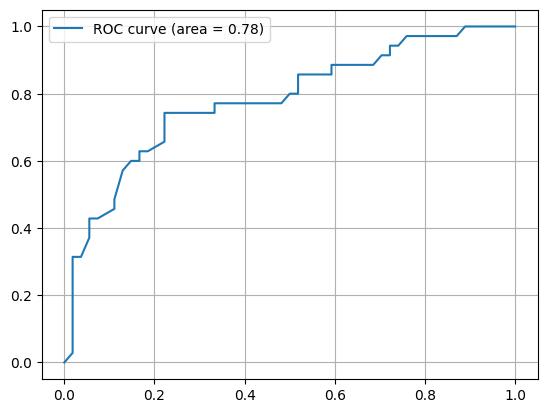

In [77]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, val_pred)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.grid()
plt.show()

In [78]:
def visualize_importance(models, feat_train_df, file_name):
    
    feature_importance_df = pd.DataFrame()

    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0,
                                          ignore_index=True
                                         )
    
    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:100]
    
    fig, ax = plt.subplots(figsize=(12, max(8, len(order) * 0.25)))
    sns.boxenplot(data=feature_importance_df,
                  x='feature_importance',
                  y='column',
                  order=order,
                  ax=ax,
                  palette='viridis',
                  orient='h'
                 )
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig, ax, order

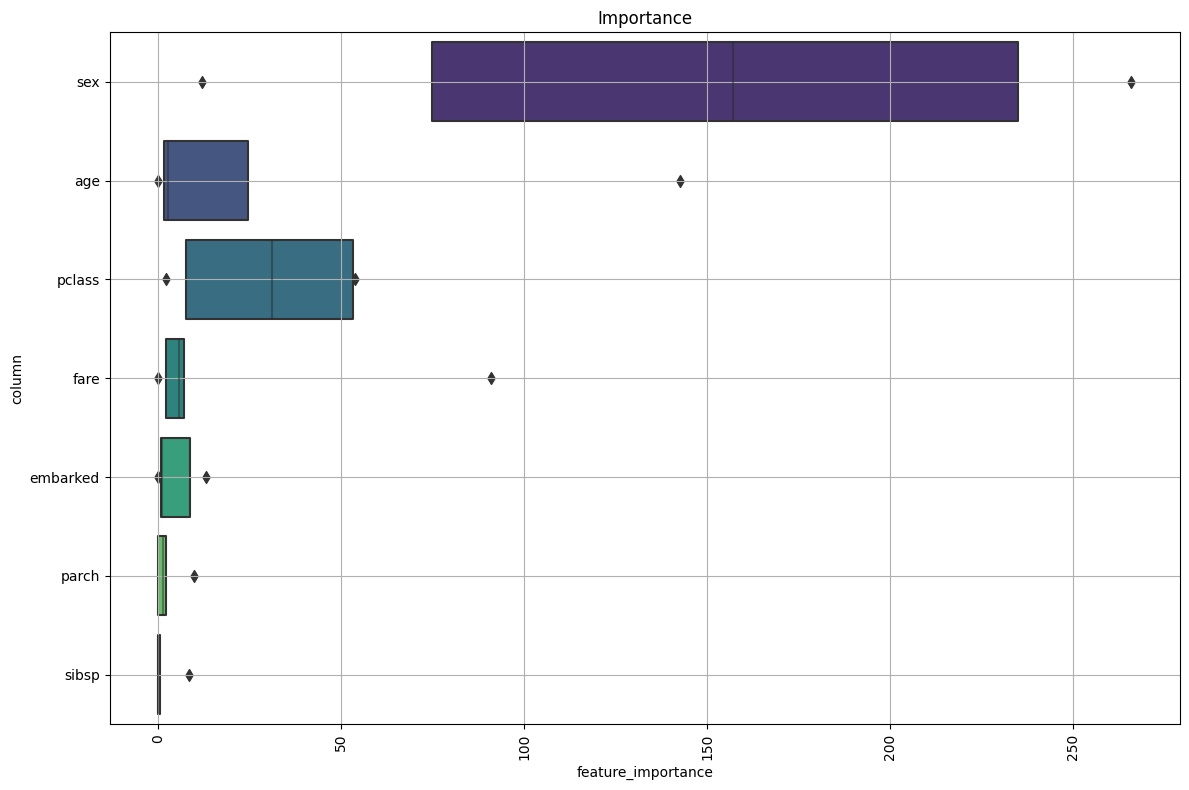

In [79]:
_ = visualize_importance(models, train.drop(columns = ["fold","survived"]), 'lgb_model')

In [81]:
score_each_model = []

for model in models:
    pred = model.predict(test)
    score_each_model.append(pred)

final_pred = sum(score_each_model)/FOLD
final_pred

array([0.24348219, 0.65304622, 0.43420154, 0.31935218, 0.38067843,
       0.42539163, 0.56292334, 0.25186354, 0.48447793, 0.56477155,
       0.30660901, 0.49337217, 0.28672915, 0.27984598, 0.49111854,
       0.41327875, 0.44324002, 0.65052319, 0.43318534, 0.42348023,
       0.23675207, 0.46212334, 0.55737812, 0.43594172, 0.26111431,
       0.35985354, 0.30578638, 0.49728496, 0.29622058, 0.26337583,
       0.64693293, 0.38706217, 0.31421259, 0.26896709, 0.36976248,
       0.33821214, 0.39888724, 0.59484024, 0.42046033, 0.40024419,
       0.38602479, 0.24523913, 0.23555771, 0.26111431, 0.35963669,
       0.47216467, 0.36326114, 0.44533684, 0.23032459, 0.35609532,
       0.3794804 , 0.37444935, 0.42469744, 0.43829111, 0.23555771,
       0.41640515, 0.29011346, 0.26305792, 0.32389605, 0.24285994,
       0.26477518, 0.54389829, 0.50285272, 0.26226496, 0.41758085,
       0.3230018 , 0.38569388, 0.23387417, 0.41988699, 0.60691372,
       0.54671493, 0.50229321, 0.45369019, 0.30769772, 0.26764

In [82]:
submit.iloc[:, 0] = final_pred
submit

,1
0,
0,0.243482
1,0.653046
2,0.434202
5,0.319352
6,0.380678
...,...
885,0.476355
886,0.306333
887,0.644866


In [83]:
submit.to_csv('submit.tsv',header=None, sep='\t')